In [1]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value, PULP_CBC_CMD,LpSolverDefault, listSolvers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import gurobipy as gp
from gurobipy import GRB
import math
import time
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

In [2]:
N = 10  
M = 4
D = 2 

In [3]:
C_K = [5, 6, 7, 6]
C_nonK = [4, 5, 4, 3]

In [4]:
T = [5, 4, 3, 2]

In [5]:
Q_K = [20, 30, 10, 40, 50, 15, 25, 35, 20, 30]
Q_nonK = [25, 35, 15, 30, 40, 20, 30, 20, 25, 35]

In [6]:
sum(Q_nonK)

275

In [7]:
sum(Q_K)

275

In [8]:
delta = [
    [4, 5, 6, 7, 4, 3, 5, 6, 8, 4, ],
    [3, 2, 3, 2, 5, 6, 7, 3, 2, 4, ],
    [6, 5, 7, 5, 6, 4, 8, 6, 5, 7, ],
    [5, 6, 4, 8, 3, 7, 6, 4, 6, 5, ],
]

In [9]:
R_K =9
R_nonK = 8

In [10]:
C_disposal =  [ [5, 4], [3, 4], [5, 3], [3, 5] ] 

In [11]:
Cap_IC = [140, 160, 130, 150]

In [12]:
Cap_disposal = [400, 450]

In [13]:
t_K = 2
t_nonK=1
t2 = 1

In [14]:
H=2

In [15]:
t10_K=7
t10_nonK=5
t20=14

In [16]:
def f(t_K, t10_K, H):
    if 0 < t_K <= t10_K:
        return H * t_K
    elif t_K > t10_K:
        return (H * t10_K)+H * (t_K-t10_K) ** 2
    else:
        return 0 

In [17]:
f(t_K, t10_K, H)

4

In [18]:
def f(t_nonK, t10_nonK, H):
    if 0 < t_nonK <= t10_nonK:
        return H * t_nonK
    elif t_nonK > t10_nonK:
        return (H * t10_nonK)+H * (t_nonK-t10_nonK) ** 2
    else:
        return 0 

In [19]:
f(t_nonK, t10_nonK, H)

2

In [20]:
def g(t2, t20, H):
    if 0 < t2 <= t20:
        return H * t2
    elif t2 > t20:
        return H * t20 +H * np.exp(t2 - t20)
    else:
        return 0

In [21]:
g(t2, t20, H)

2

In [22]:
p_K = 0.05
p_nonK = 0.10

In [23]:
model = LpProblem("Reverse_Logistics_Optimization", LpMinimize)

In [24]:
x = LpVariable.dicts("x", (range(M), range(N)), cat='Binary')  
y = LpVariable.dicts("y", (range(M), range(N)), cat='Binary')  
z = LpVariable.dicts("z", (range(M), range(N)), cat='Binary')  
z_K = LpVariable.dicts("z_K", (range(M), range(N), range(D)), cat='Binary')  
z_nonK = LpVariable.dicts("z_nonK", (range(M), range(N), range(D)), cat='Binary')  
w = LpVariable.dicts("w", (range(M), range(D)), cat='Binary')

In [25]:
inspection_cost= lpSum(C_K[i] * Q_K[j] * x[i][j] for i in range(M) for j in range(N)) + \
    lpSum(C_nonK[i] * Q_nonK[j] * y[i][j] for i in range(M) for j in range(N))

In [26]:
transportation_cost= lpSum(T[i] * delta[i][j] * (x[i][j] + y[i][j] - z[i][j]) for i in range(M) for j in range(N))

In [27]:
holding_cost_K= f(t_K, t10_K, H) * lpSum( Q_K[j] * x[i][j]  for i in range(M) for j in range(N))

In [28]:
holding_cost_nonK= f(t_nonK, t10_nonK, H) * lpSum(Q_nonK[j] * y[i][j] for i in range(M) for j in range(N))

In [29]:
disposable_holding_cost = g(t2, t20, H) * lpSum(p_K * Q_K[j] * x[i][j] + p_nonK * Q_nonK[j] * y[i][j] for i in range(M) for j in range(N))

In [30]:
waiting_time_cost= lpSum(
    H * (t_K - t_nonK) * p_nonK * Q_nonK[j] * y[i][j]
    for i in range(M) for j in range(N)
)

In [31]:
repackaging_cost= R_K * lpSum((1 - p_K) * lpSum(Q_K[j] * x[i][j] for j in range(N)) for i in range(M)) + \
    R_nonK * lpSum( (1 - p_nonK) * lpSum(Q_nonK[j] * y[i][j] for j in range(N)) for i in range(M))

In [32]:
disposal_cost= lpSum((C_disposal[i][d]) * (
        p_K * lpSum(Q_K[j] * z_K[i][j][d] for j in range(N)) + \
        p_nonK * lpSum(Q_nonK[j] * z_nonK[i][j][d] for j in range(N))
    ) for i in range(M) for d in range(D))

In [33]:
model += inspection_cost + transportation_cost+ holding_cost_K+holding_cost_nonK+ disposable_holding_cost+waiting_time_cost+ repackaging_cost + disposal_cost

In [34]:
for j in range(N):
    model += lpSum(x[i][j] for i in range(M)) == 1  
    model += lpSum(y[i][j] for i in range(M)) == 1 

In [35]:
for i in range(M):
    model += lpSum(Q_K[j] * x[i][j] + Q_nonK[j] * y[i][j] for j in range(N)) <= Cap_IC[i]

In [36]:
for i in range(M):
    model += lpSum(w[i][d] for d in range(D)) == 1

In [37]:
for i in range(M):
    for j in range(N):
        model += z[i][j] <= x[i][j]
        model += z[i][j] <= y[i][j]
        model += z[i][j] >= x[i][j] + y[i][j] - 1

In [38]:
for i in range(M):
    for j in range(N):
        for d in range(D):
            model += z_K[i][j][d] <= x[i][j]  
            model += z_nonK[i][j][d] <= y[i][j]  
            model += z_K[i][j][d] <= w[i][d]  
            model += z_nonK[i][j][d] <= w[i][d]  
            
            model += z_K[i][j][d] >= x[i][j] + w[i][d] - 1
            model += z_nonK[i][j][d] >= y[i][j] + w[i][d] - 1

In [39]:
for d in range(D):
    model += lpSum(p_K * Q_K[j] * z_K[i][j][d] + p_nonK * Q_nonK[j] * z_nonK[i][j][d] 
                   for i in range(M) for j in range(N)) <= Cap_disposal[d]

In [40]:
model.solve(PULP_CBC_CMD(msg=True, options=[]))

1

In [41]:
model.solve(PULP_CBC_CMD(msg=True, cuts=True))

1

In [42]:
#model.solve()
print("Status:", LpStatus[model.status])

Status: Optimal


In [43]:
objective_value = model.objective.value()
print("Objective value:", objective_value)

Objective value: 8975.5


In [44]:
import pulp
model.solve(pulp.PULP_CBC_CMD(msg=True, logPath="cbc_log.txt"))

C:\Users\biley\AppData\Local\Programs\Python\Python310\lib\site-packages\pulp\apis\coin_api.py:161: UserWarning: `logPath` argument replaces `msg=1`. The output will be redirected to the log file.
  warnings.warn(


1

In [45]:
print(f"Default solver being used: {LpSolverDefault.msg}")

Default solver being used: True


In [46]:
print("Available solvers in PuLP:")
print(listSolvers(onlyAvailable=True))

print("\nDefault solver being used:")
print(LpSolverDefault)

Available solvers in PuLP:
['GUROBI', 'PULP_CBC_CMD']

Default solver being used:


In [47]:
waiting_time_cost.value()

55.0

In [48]:
inspection_cost.value()

2490.0

In [49]:
transportation_cost.value()

235.0

In [50]:
holding_cost_K.value()

1100.0

In [51]:
holding_cost_nonK.value()

550.0

In [52]:
disposable_holding_cost.value()

82.5

In [53]:
repackaging_cost.value()  

4331.25

In [54]:
disposal_cost.value()

131.75

In [55]:
for i in range(M):
    for j in range(N):
        if x[i][j].varValue > 0:
            print(f"Send Critical medicine from Node {j + 1} to IC {i + 1}")
        if y[i][j].varValue > 0:
            print(f"Send Non-Critical medicine from Node {j + 1} to IC {i + 1}")
for i in range(M):
    for d in range(D):
        
        if any(z_K[i][j][d].varValue == 1 for j in range(N)) or any(z_nonK[i][j][d].varValue == 1 for j in range(N)):
            print(f"Send disposable medicine from IC {i + 1} to Disposal Center {d + 1}")

Send Critical medicine from Node 5 to IC 1
Send Critical medicine from Node 6 to IC 1
Send Non-Critical medicine from Node 6 to IC 1
Send Critical medicine from Node 7 to IC 1
Send Critical medicine from Node 10 to IC 1
Send Critical medicine from Node 1 to IC 2
Send Critical medicine from Node 2 to IC 2
Send Critical medicine from Node 4 to IC 2
Send Critical medicine from Node 8 to IC 2
Send Critical medicine from Node 9 to IC 2
Send Non-Critical medicine from Node 1 to IC 3
Send Non-Critical medicine from Node 2 to IC 3
Send Non-Critical medicine from Node 4 to IC 3
Send Non-Critical medicine from Node 9 to IC 3
Send Critical medicine from Node 3 to IC 4
Send Non-Critical medicine from Node 3 to IC 4
Send Non-Critical medicine from Node 5 to IC 4
Send Non-Critical medicine from Node 7 to IC 4
Send Non-Critical medicine from Node 8 to IC 4
Send Non-Critical medicine from Node 10 to IC 4
Send disposable medicine from IC 1 to Disposal Center 2
Send disposable medicine from IC 2 to Disp

In [56]:
print("Assignment Matrix for Critical Medicine (x):")
for i in range(M):
    row = [x[i][j].varValue for j in range(N)]
    print(f"IC {i + 1}: {row}")

print("Assignment Matrix for Non-Critical Medicine (y):")
for i in range(M):
    row = [y[i][j].varValue for j in range(N)]
    print(f"IC {i + 1}: {row}")

Assignment Matrix for Critical Medicine (x):
IC 1: [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0]
IC 2: [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]
IC 3: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
IC 4: [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Assignment Matrix for Non-Critical Medicine (y):
IC 1: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
IC 2: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
IC 3: [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
IC 4: [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0]


In [57]:
z_K_matrix = [[[0 for d in range(D)] for j in range(N)] for i in range(M)]
z_nonK_matrix = [[[0 for d in range(D)] for j in range(N)] for i in range(M)]

# Retrieve the values
for i in range(M):
    for j in range(N):
        for d in range(D):
            z_K_matrix[i][j][d] = z_K[i][j][d].value()
            z_nonK_matrix[i][j][d] = z_nonK[i][j][d].value()

print("z_K matrix:")
print(z_K_matrix)

print("z_nonK matrix:")
print(z_nonK_matrix)


z_K matrix:
[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 0.0], [0.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [1.0, 0.0], [0.0, 0.0], [1.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 0.0]], [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]], [[0.0, 0.0], [0.0, 0.0], [1.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]]
z_nonK matrix:
[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 1.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]], [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]], [[0.0, 1.0], [0.0, 1.0], [0.0, 0.0], [0.0, 1.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 1.0], [0.0, 0.0]], [[0.0, 0.0], [0.0, 0.0], [1.0, 0.0], [0.0, 0.0], [1.0, 0.0], [0.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 0.0], [1.0, 0.

In [58]:
print("Assignment Matrix for Medicines to Disposal Centers (Combined):")
print("     D1   D2")  

for i in range(M):
    row = []
    for d in range(D):
        
        if any(z_K[i][j][d].varValue == 1 for j in range(N)) or any(z_nonK[i][j][d].varValue == 1 for j in range(N)):
            row.append(1) 
        else:
            row.append(0)  
    print(f"IC {i + 1}: {row[0]} {row[1]}")  

Assignment Matrix for Medicines to Disposal Centers (Combined):
     D1   D2
IC 1: 0 1
IC 2: 1 0
IC 3: 0 1
IC 4: 1 0


In [59]:
from tabulate import tabulate

disposal_header = ["IC \\ D"] + [f"D{d+1}" for d in range(D)]
disposal_rows = []

for i in range(M):
    row = [f"IC {i+1}"]
    for d in range(D):
        
        assigned = 1 if any(z_K[i][j][d].varValue == 1 for j in range(N)) or any(z_nonK[i][j][d].varValue == 1 for j in range(N)) else 0
        row.append(assigned)
    disposal_rows.append(row)


print("Assignment Matrix for Medicines to Disposal Centers :")
print(tabulate(disposal_rows, headers=disposal_header, tablefmt="grid"))


Assignment Matrix for Medicines to Disposal Centers :
+----------+------+------+
| IC \ D   |   D1 |   D2 |
+==========+======+======+
| IC 1     |    0 |    1 |
+----------+------+------+
| IC 2     |    1 |    0 |
+----------+------+------+
| IC 3     |    0 |    1 |
+----------+------+------+
| IC 4     |    1 |    0 |
+----------+------+------+


In [60]:
print("\nQuantities Received at Each Inspection Center:")
for i in range(M):
    critical_qty = sum(Q_K[j] * x[i][j].varValue for j in range(N))
    non_critical_qty = sum(Q_nonK[j] * y[i][j].varValue for j in range(N))
    total_qty = critical_qty + non_critical_qty
    print(f"IC {i + 1}: Critical = {critical_qty}, Non-Critical = {non_critical_qty}, Total = {total_qty}")


Quantities Received at Each Inspection Center:
IC 1: Critical = 120.0, Non-Critical = 20.0, Total = 140.0
IC 2: Critical = 145.0, Non-Critical = 0.0, Total = 145.0
IC 3: Critical = 0.0, Non-Critical = 115.0, Total = 115.0
IC 4: Critical = 10.0, Non-Critical = 140.0, Total = 150.0


In [61]:
print("\nQuantities Received at Each Disposal Center:")
for d in range(D):
    total_quantity = sum(
        (p_K * Q_K[j] * z_K[i][j][d].varValue + p_nonK * Q_nonK[j] * z_nonK[i][j][d].varValue)
        for i in range(M) for j in range(N)
    )
    print(f"Disposal Center {d + 1}: Total Quantity = {total_quantity:.2f}")


Quantities Received at Each Disposal Center:
Disposal Center 1: Total Quantity = 21.75
Disposal Center 2: Total Quantity = 19.50


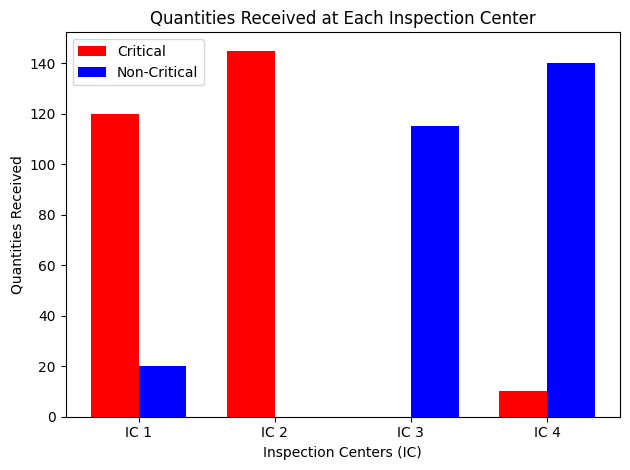

In [62]:
ic_indices = np.arange(M)  
critical_qtys = [sum(Q_K[j] * x[i][j].varValue for j in range(N)) for i in range(M)]
non_critical_qtys = [sum(Q_nonK[j] * y[i][j].varValue for j in range(N)) for i in range(M)]

bar_width = 0.35

plt.bar(ic_indices, critical_qtys, width=bar_width, label='Critical', color='red', align='center')
plt.bar(ic_indices + bar_width, non_critical_qtys, width=bar_width, label='Non-Critical', color='blue', align='center')


plt.xlabel('Inspection Centers (IC)')
plt.ylabel('Quantities Received')
plt.title('Quantities Received at Each Inspection Center')
plt.xticks(ic_indices + bar_width / 2, [f'IC {i + 1}' for i in range(M)])  
plt.legend()
plt.tight_layout()

plt.show()

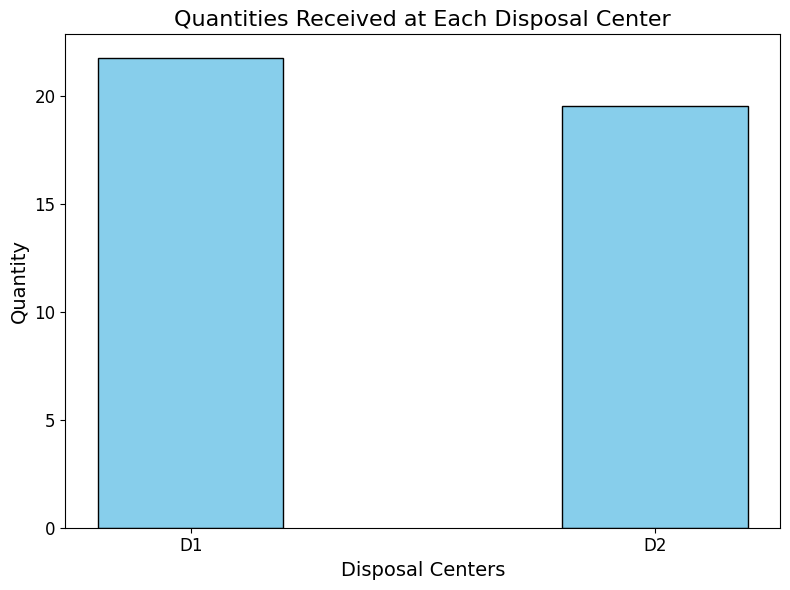

In [63]:
D = 2  
disposal_centers = [f"D{d + 1}" for d in range(D)]  
quantities = []


for d in range(D):
    total_quantity = sum(
        (p_K * Q_K[j] * z_K[i][j][d].varValue + p_nonK * Q_nonK[j] * z_nonK[i][j][d].varValue)
        for i in range(M) for j in range(N)
    )
    quantities.append(total_quantity)


x_positions = np.arange(D) * 0.25  


plt.figure(figsize=(8, 6))
plt.bar(x_positions, quantities, color='skyblue', edgecolor='black', width=0.1)


plt.xticks(x_positions, disposal_centers, fontsize=12)


plt.xlabel('Disposal Centers', fontsize=14)
plt.ylabel('Quantity', fontsize=14)
plt.title('Quantities Received at Each Disposal Center', fontsize=16)
plt.yticks(fontsize=12)


plt.tight_layout()
plt.show()


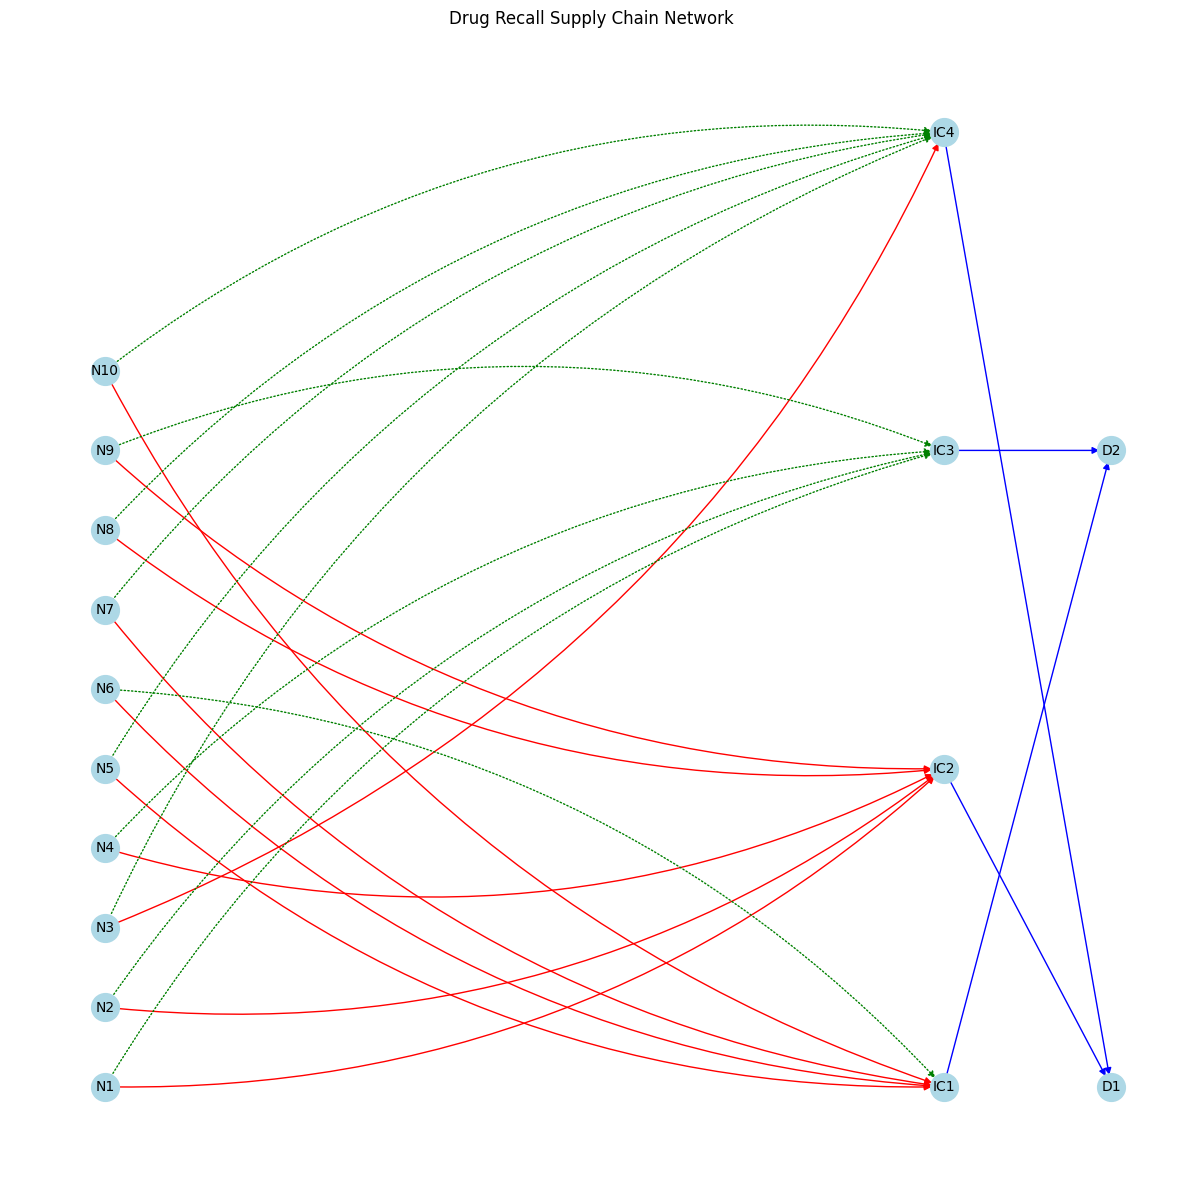

In [64]:
G = nx.DiGraph()


nodes = [f'N{i+1}' for i in range(N)]
ics = [f'IC{i+1}' for i in range(M)]
disposals = [f'D{i+1}' for i in range(D)]

G.add_nodes_from(nodes, layer=1)
G.add_nodes_from(ics, layer=2)
G.add_nodes_from(disposals, layer=3)


critical_edge_labels = {}
non_critical_edge_labels = {}
disposal_edge_labels = {}


for i in range(M):
    for j in range(N):
        if x[i][j].varValue > 0: 
            qty = Q_K[j] * x[i][j].varValue  
            G.add_edge(f'N{j+1}', f'IC{i+1}')
            critical_edge_labels[(f'N{j+1}', f'IC{i+1}')] = '' #f'{qty:.2f}'  

for i in range(M):
    for j in range(N):
        if y[i][j].varValue > 0:  
            qty = Q_nonK[j] * y[i][j].varValue  
            G.add_edge(f'N{j+1}', f'IC{i+1}')
            non_critical_edge_labels[(f'N{j+1}', f'IC{i+1}')] = '' # f'{qty:.2f}'  


for i in range(M):
    for d in range(D):
        if any(z_K[i][j][d].varValue == 1 for j in range(N)) or any(z_nonK[i][j][d].varValue == 1 for j in range(N)):
            G.add_edge(f'IC{i+1}', f'D{d+1}')
            disposal_edge_labels[(f'IC{i+1}', f'D{d+1}')] = '' 


pos = {}
for i, node in enumerate(nodes):
    pos[node] = (-4.0, i)  

for i, ic in enumerate(ics):
    pos[ic] = (1, i * 4)  

for i, disposal in enumerate(disposals):
    pos[disposal] = (2, i * 8)  


plt.figure(figsize=(15, 15))
nx.draw_networkx_edges(G, pos, edgelist=critical_edge_labels.keys(), edge_color='red', arrows=True,
                       connectionstyle='arc3,rad=0.2')  
nx.draw_networkx_edges(G, pos, edgelist=non_critical_edge_labels.keys(), style='dotted', edge_color='green', arrows=True,
                       connectionstyle='arc3,rad=-0.2')  
nx.draw_networkx_edges(G, pos, edgelist=disposal_edge_labels.keys(), edge_color='blue', arrows=True)

nx.draw_networkx_nodes(G, pos, node_size=400, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=critical_edge_labels, font_color='red')
nx.draw_networkx_edge_labels(G, pos, edge_labels=non_critical_edge_labels, font_color='green')
nx.draw_networkx_edge_labels(G, pos, edge_labels=disposal_edge_labels, font_color='blue')

plt.title("Drug Recall Supply Chain Network")
plt.axis('off')
plt.show()

In [65]:
from tabulate import tabulate

# Prepare the data for the Critical Medicine matrix
critical_header = ["IC \\ N"] + [f"N{j+1}" for j in range(N)]
critical_rows = [[f"IC {i+1}"] + [x[i][j].varValue for j in range(N)] for i in range(M)]

# Prepare the data for the Non-Critical Medicine matrix
non_critical_header = ["IC \\ N"] + [f"N{j+1}" for j in range(N)]
non_critical_rows = [[f"IC {i+1}"] + [y[i][j].varValue for j in range(N)] for i in range(M)]

# Print the matrices
print("Assignment Matrix for Critical Medicine (x):")
print(tabulate(critical_rows, headers=critical_header, tablefmt="grid"))

print("\nAssignment Matrix for Non-Critical Medicine (y):")
print(tabulate(non_critical_rows, headers=non_critical_header, tablefmt="grid"))



Assignment Matrix for Critical Medicine (x):
+----------+------+------+------+------+------+------+------+------+------+-------+
| IC \ N   |   N1 |   N2 |   N3 |   N4 |   N5 |   N6 |   N7 |   N8 |   N9 |   N10 |
+==========+======+======+======+======+======+======+======+======+======+=======+
| IC 1     |    0 |    0 |    0 |    0 |    1 |    1 |    1 |    0 |    0 |     1 |
+----------+------+------+------+------+------+------+------+------+------+-------+
| IC 2     |    1 |    1 |    0 |    1 |    0 |    0 |    0 |    1 |    1 |     0 |
+----------+------+------+------+------+------+------+------+------+------+-------+
| IC 3     |    0 |    0 |    0 |    0 |    0 |    0 |    0 |    0 |    0 |     0 |
+----------+------+------+------+------+------+------+------+------+------+-------+
| IC 4     |    0 |    0 |    1 |    0 |    0 |    0 |    0 |    0 |    0 |     0 |
+----------+------+------+------+------+------+------+------+------+------+-------+

Assignment Matrix for Non-Crit

In [66]:
p_K = 0.05
p_nonK = 0.10

In [67]:
results = []

t_K_values = np.array([1, 2, 3, 4, 5, 6, 7,8,9,10,11])
t_nonK_values = np.array([1, 2, 3, 4, 5, 6, 7,8,9,10,11])
t2_values = range(1, 19)


for t_K in t_K_values:
    for t_nonK in t_nonK_values:
        if t_K > t_nonK:  
            for t2 in t2_values:
                
                model = LpProblem("Reverse_Logistics_Optimization", LpMinimize)

               
                x = LpVariable.dicts("x", (range(M), range(N)), cat='Binary')  
                y = LpVariable.dicts("y", (range(M), range(N)), cat='Binary')  
                z = LpVariable.dicts("z", (range(M), range(N)), cat='Binary')  
                z_K = LpVariable.dicts("z_K", (range(M), range(N), range(D)), cat='Binary')  
                z_nonK = LpVariable.dicts("z_nonK", (range(M), range(N), range(D)), cat='Binary')  
                w = LpVariable.dicts("w", (range(M), range(D)), cat='Binary')

                
                inspection_cost = lpSum(C_K[i] * Q_K[j] * x[i][j] for i in range(M) for j in range(N)) + \
                    lpSum(C_nonK[i] * Q_nonK[j] * y[i][j] for i in range(M) for j in range(N))

                transportation_cost = lpSum(T[i] * delta[i][j] * (x[i][j] + y[i][j] - z[i][j]) for i in range(M) for j in range(N))

                holding_cost_K = f(t_K, t10_K, H) * lpSum(Q_K[j] * x[i][j] for i in range(M) for j in range(N))
                holding_cost_nonK = f(t_nonK, t10_nonK, H) * lpSum(Q_nonK[j] * y[i][j] for i in range(M) for j in range(N))
                disposable_holding_cost = g(t2, t20, H) * lpSum(
                    p_K * Q_K[j] * x[i][j] + p_nonK * Q_nonK[j] * y[i][j]
                    for i in range(M) for j in range(N)
                )

                waiting_time_cost = lpSum(
                    H * (t_K - t_nonK) * p_nonK * Q_nonK[j] * y[i][j]
                    for i in range(M) for j in range(N)
                )

                repackaging_cost = R_K *lpSum( (1 - p_K) * lpSum(Q_K[j] * x[i][j] for j in range(N)) for i in range(M)) + \
                    R_nonK * lpSum( (1 - p_nonK) * lpSum(Q_nonK[j] * y[i][j] for j in range(N)) for i in range(M))

                disposal_cost = lpSum((C_disposal[i][d]) * (
                        p_K * lpSum(Q_K[j] * z_K[i][j][d] for j in range(N)) + \
                        p_nonK * lpSum(Q_nonK[j] * z_nonK[i][j][d] for j in range(N))
                    ) for i in range(M) for d in range(D))

                
                model += inspection_cost + transportation_cost + holding_cost_K + holding_cost_nonK + disposable_holding_cost + waiting_time_cost + repackaging_cost + disposal_cost

                
                for j in range(N):
                    model += lpSum(x[i][j] for i in range(M)) == 1  
                    model += lpSum(y[i][j] for i in range(M)) == 1

                for i in range(M):
                    model += lpSum(Q_K[j] * x[i][j] + Q_nonK[j] * y[i][j] for j in range(N)) <= Cap_IC[i]

                for i in range(M):
                    model += lpSum(w[i][d] for d in range(D)) == 1

                for i in range(M):
                    for j in range(N):
                        model += z[i][j] <= x[i][j]
                        model += z[i][j] <= y[i][j]
                        model += z[i][j] >= x[i][j] + y[i][j] - 1

                for i in range(M):
                    for j in range(N):
                        for d in range(D):
                            model += z_K[i][j][d] <= x[i][j]  
                            model += z_nonK[i][j][d] <= y[i][j]  
                            model += z_K[i][j][d] <= w[i][d]  
                            model += z_nonK[i][j][d] <= w[i][d]  
                            
                            model += z_K[i][j][d] >= x[i][j] + w[i][d] - 1
                            model += z_nonK[i][j][d] >= y[i][j] + w[i][d] - 1

                for d in range(D):
                    model += lpSum(p_K * Q_K[j] * z_K[i][j][d] + p_nonK * Q_nonK[j] * z_nonK[i][j][d] 
                                   for i in range(M) for j in range(N)) <= Cap_disposal[d]

                
                model.solve()

                
                results.append({
                    "t_K": t_K,
                    "t_nonK": t_nonK,
                    "t2": t2,
                    "inspection_cost":inspection_cost.value(),
                    "transportation_cost": transportation_cost.value(),
                    "holding_cost_K": holding_cost_K.value(),
                    "holding_cost_nonK": holding_cost_nonK.value(),
                    "waiting_time_cost":waiting_time_cost.value(),
                    "disposable_holding_cost":disposable_holding_cost.value(),
                    "repackaging_cost": repackaging_cost.value(),
                    "disposal_cost": disposal_cost.value(),
                    "objective_value": model.objective.value()
                })


df = pd.DataFrame(results).round(2)

In [68]:
df['disposable_holding_cost'].unique()

array([  82.5 ,  165.  ,  247.5 ,  330.  ,  412.5 ,  495.  ,  577.5 ,
        660.  ,  742.5 ,  825.  ,  907.5 ,  990.  , 1072.5 , 1155.  ,
       1379.26, 1764.6 , 2812.06, 5659.35])

In [69]:
df

,t_K,t_nonK,t2,inspection_cost,transportation_cost,holding_cost_K,holding_cost_nonK,waiting_time_cost,disposable_holding_cost,repackaging_cost,disposal_cost,objective_value
0,2,1,1,2490.0,235.0,1100.0,550.0,55.0,82.50,4331.25,131.75,8975.50
1,2,1,2,2490.0,235.0,1100.0,550.0,55.0,165.00,4331.25,131.75,9058.00
2,2,1,3,2490.0,235.0,1100.0,550.0,55.0,247.50,4331.25,131.75,9140.50
3,2,1,4,2490.0,235.0,1100.0,550.0,55.0,330.00,4331.25,131.75,9223.00
4,2,1,5,2490.0,235.0,1100.0,550.0,55.0,412.50,4331.25,131.75,9305.50
...,...,...,...,...,...,...,...,...,...,...,...,...
985,11,10,14,2490.0,235.0,12650.0,16500.0,55.0,1155.00,4331.25,131.75,37548.00
986,11,10,15,2490.0,235.0,12650.0,16500.0,55.0,1379.26,4331.25,131.75,37772.26
987,11,10,16,2490.0,235.0,12650.0,16500.0,55.0,1764.60,4331.25,131.75,38157.60
988,11,10,17,2490.0,235.0,12650.0,16500.0,55.0,2812.06,4331.25,131.75,39205.06


In [70]:
df['inspection_cost'].unique()

array([2490., 2475.])

In [71]:
df['transportation_cost'].unique()

array([235., 251.])

In [72]:
df['disposal_cost'].unique()

array([131.75, 130.75])

In [73]:
df.to_excel('result_1.xlsx', index=False)
print("File saved as 'result_1.xlsx'")

File saved as 'result_1.xlsx'


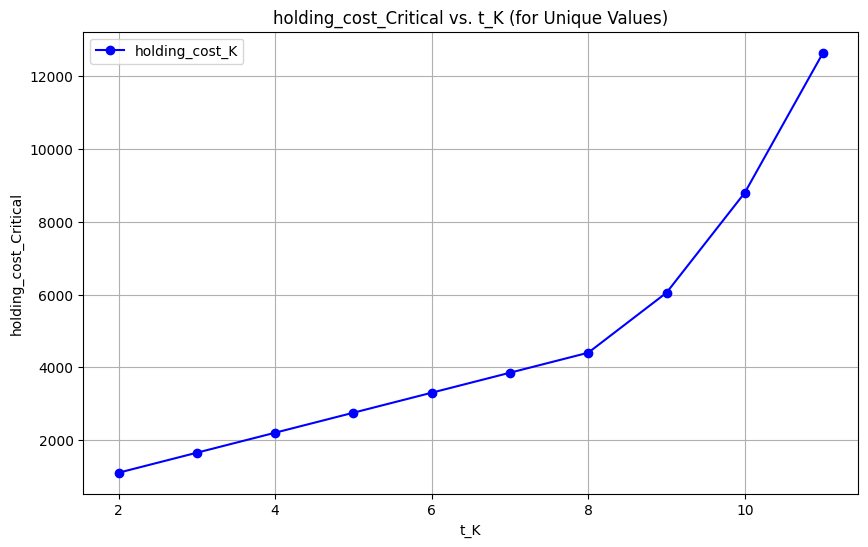

In [74]:
unique_t2_data = df[['t_K', 'holding_cost_K']].drop_duplicates()

plt.figure(figsize=(10, 6))
plt.plot(unique_t2_data['t_K'], unique_t2_data['holding_cost_K'], marker='o', color='b', label='holding_cost_K')
plt.title('holding_cost_Critical vs. t_K (for Unique Values)')
plt.xlabel('t_K')
plt.ylabel('holding_cost_Critical')

plt.legend()
plt.grid(True)
plt.show()

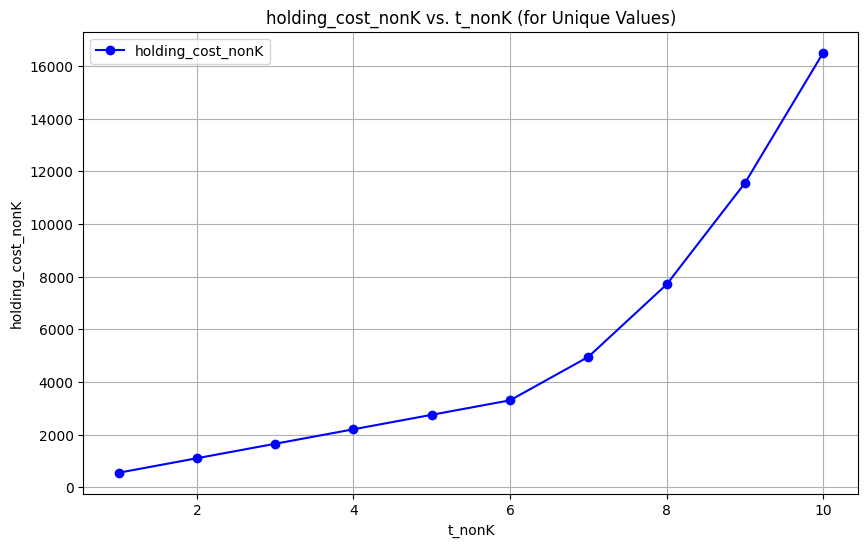

In [75]:
unique_t2_data = df[['t_nonK', 'holding_cost_nonK']].drop_duplicates()

plt.figure(figsize=(10, 6))
plt.plot(unique_t2_data['t_nonK'], unique_t2_data['holding_cost_nonK'], marker='o', color='b', label='holding_cost_nonK')
plt.title('holding_cost_nonK vs. t_nonK (for Unique Values)')
plt.xlabel('t_nonK')
plt.ylabel('holding_cost_nonK')

plt.legend()
plt.grid(True)
plt.show()

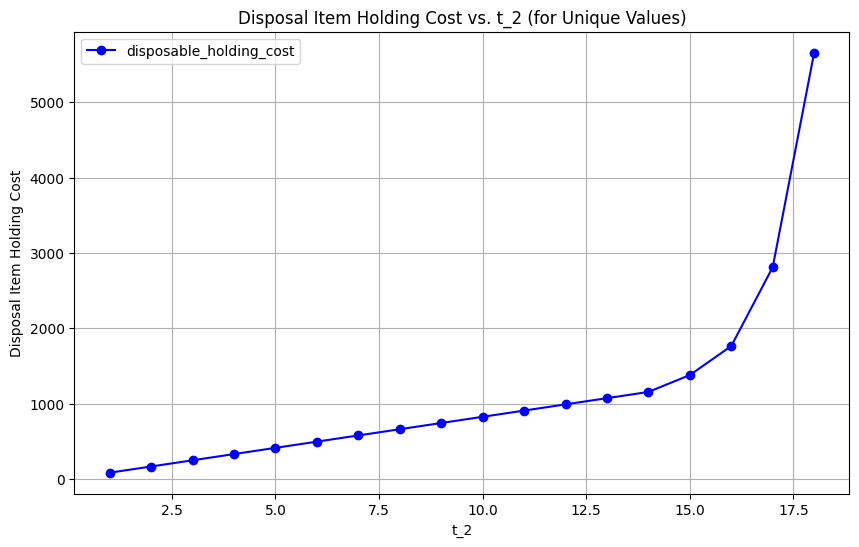

In [76]:
unique_t2_data = df[['t2', 'disposable_holding_cost']].drop_duplicates()

plt.figure(figsize=(10, 6))
plt.plot(unique_t2_data['t2'], unique_t2_data['disposable_holding_cost'], marker='o', color='b', label='disposable_holding_cost')
plt.title('Disposal Item Holding Cost vs. t_2 (for Unique Values)')
plt.xlabel('t_2')
plt.ylabel('Disposal Item Holding Cost')

plt.legend()
plt.grid(True)
plt.show()

In [77]:
t_K = 2
t_nonK=1
t2 = 1

In [78]:
results = []

p_K_values = np.array([0.05,0.10,0.15])
p_nonK_values = np.array([0.10,0.15,0.20])



for p_K in p_K_values:
    for p_nonK in p_nonK_values:
        if p_K < p_nonK:  
                
                model = LpProblem("Reverse_Logistics_Optimization", LpMinimize)

               
                x = LpVariable.dicts("x", (range(M), range(N)), cat='Binary')  
                y = LpVariable.dicts("y", (range(M), range(N)), cat='Binary')  
                z = LpVariable.dicts("z", (range(M), range(N)), cat='Binary')  
                z_K = LpVariable.dicts("z_K", (range(M), range(N), range(D)), cat='Binary')  
                z_nonK = LpVariable.dicts("z_nonK", (range(M), range(N), range(D)), cat='Binary')  
                w = LpVariable.dicts("w", (range(M), range(D)), cat='Binary')

                
                inspection_cost = lpSum(C_K[i] * Q_K[j] * x[i][j] for i in range(M) for j in range(N)) + \
                    lpSum(C_nonK[i] * Q_nonK[j] * y[i][j] for i in range(M) for j in range(N))

                transportation_cost = lpSum(T[i] * delta[i][j] * (x[i][j] + y[i][j] - z[i][j]) for i in range(M) for j in range(N))

                holding_cost_K = f(t_K, t10_K, H) * lpSum(Q_K[j] * x[i][j] for i in range(M) for j in range(N))
                holding_cost_nonK = f(t_nonK, t10_nonK, H) * lpSum(Q_nonK[j] * y[i][j] for i in range(M) for j in range(N))
                disposable_holding_cost = g(t2, t20, H) * lpSum(
                    p_K * Q_K[j] * x[i][j] + p_nonK * Q_nonK[j] * y[i][j]
                    for i in range(M) for j in range(N)
                )

                waiting_time_cost = lpSum(
                    H * (t_K - t_nonK) * p_nonK * Q_nonK[j] * y[i][j]
                    for i in range(M) for j in range(N)
                )

                repackaging_cost = R_K *lpSum( (1 - p_K) * lpSum(Q_K[j] * x[i][j] for j in range(N)) for i in range(M)) + \
                    R_nonK * lpSum( (1 - p_nonK) * lpSum(Q_nonK[j] * y[i][j] for j in range(N)) for i in range(M))

                disposal_cost = lpSum((C_disposal[i][d]) * (
                        p_K * lpSum(Q_K[j] * z_K[i][j][d] for j in range(N)) + \
                        p_nonK * lpSum(Q_nonK[j] * z_nonK[i][j][d] for j in range(N))
                    ) for i in range(M) for d in range(D))

                
                model += inspection_cost + transportation_cost + holding_cost_K + holding_cost_nonK + disposable_holding_cost + waiting_time_cost + repackaging_cost + disposal_cost

                
                for j in range(N):
                    model += lpSum(x[i][j] for i in range(M)) == 1  
                    model += lpSum(y[i][j] for i in range(M)) == 1

                for i in range(M):
                    model += lpSum(Q_K[j] * x[i][j] + Q_nonK[j] * y[i][j] for j in range(N)) <= Cap_IC[i]

                for i in range(M):
                    model += lpSum(w[i][d] for d in range(D)) == 1

                for i in range(M):
                    for j in range(N):
                        model += z[i][j] <= x[i][j]
                        model += z[i][j] <= y[i][j]
                        model += z[i][j] >= x[i][j] + y[i][j] - 1

                for i in range(M):
                    for j in range(N):
                        for d in range(D):
                            model += z_K[i][j][d] <= x[i][j]  
                            model += z_nonK[i][j][d] <= y[i][j]  
                            model += z_K[i][j][d] <= w[i][d]  
                            model += z_nonK[i][j][d] <= w[i][d]  
                            
                            model += z_K[i][j][d] >= x[i][j] + w[i][d] - 1
                            model += z_nonK[i][j][d] >= y[i][j] + w[i][d] - 1

                for d in range(D):
                    model += lpSum(p_K * Q_K[j] * z_K[i][j][d] + p_nonK * Q_nonK[j] * z_nonK[i][j][d] 
                                   for i in range(M) for j in range(N)) <= Cap_disposal[d]

                
                model.solve()

                
                results.append({
                    "p_K": p_K,
                    "p_nonK": p_nonK,
                    "inspection_cost":inspection_cost.value(),
                    "transportation_cost": transportation_cost.value(),
                    "holding_cost_K": holding_cost_K.value(),
                    "holding_cost_nonK": holding_cost_nonK.value(),
                    "waiting_time_cost":waiting_time_cost.value(),
                    "disposable_holding_cost":disposable_holding_cost.value(),
                    "repackaging_cost": repackaging_cost.value(),
                    "disposal_cost": disposal_cost.value(),
                    "objective_value": model.objective.value()
                })


df1 = pd.DataFrame(results).round(2)

In [79]:
df1

,p_K,p_nonK,inspection_cost,transportation_cost,holding_cost_K,holding_cost_nonK,waiting_time_cost,disposable_holding_cost,repackaging_cost,disposal_cost,objective_value
0,0.05,0.10,2490.0,235.0,1100.0,550.0,55.0,82.5,4331.25,131.75,8975.50
1,0.05,0.15,2475.0,251.0,1100.0,550.0,82.5,110.0,4221.25,172.00,8961.75
2,0.05,0.20,2475.0,251.0,1100.0,550.0,110.0,137.5,4111.25,213.25,8948.00
3,0.10,0.15,2490.0,235.0,1100.0,550.0,82.5,137.5,4097.50,221.25,8913.75
4,0.10,0.20,2475.0,251.0,1100.0,550.0,110.0,165.0,3987.50,261.50,8900.00
5,0.15,0.20,2475.0,251.0,1100.0,550.0,110.0,192.5,3863.75,309.75,8852.00


In [80]:
base_value = df1['objective_value'].iloc[0] 
df1['percentage_change_obj_V'] = ((df1['objective_value'] - base_value) / base_value) * 100
print(df1)

    p_K  p_nonK  inspection_cost  transportation_cost  holding_cost_K  \
0  0.05    0.10           2490.0                235.0          1100.0   
1  0.05    0.15           2475.0                251.0          1100.0   
2  0.05    0.20           2475.0                251.0          1100.0   
3  0.10    0.15           2490.0                235.0          1100.0   
4  0.10    0.20           2475.0                251.0          1100.0   
5  0.15    0.20           2475.0                251.0          1100.0   

   holding_cost_nonK  waiting_time_cost  disposable_holding_cost  \
0              550.0               55.0                     82.5   
1              550.0               82.5                    110.0   
2              550.0              110.0                    137.5   
3              550.0               82.5                    137.5   
4              550.0              110.0                    165.0   
5              550.0              110.0                    192.5   

   repackag

In [81]:
base_value = df1['repackaging_cost'].iloc[0] 
df1['percentage_change_repack'] = ((df1['repackaging_cost'] - base_value) / base_value) * 100
print(df1)

    p_K  p_nonK  inspection_cost  transportation_cost  holding_cost_K  \
0  0.05    0.10           2490.0                235.0          1100.0   
1  0.05    0.15           2475.0                251.0          1100.0   
2  0.05    0.20           2475.0                251.0          1100.0   
3  0.10    0.15           2490.0                235.0          1100.0   
4  0.10    0.20           2475.0                251.0          1100.0   
5  0.15    0.20           2475.0                251.0          1100.0   

   holding_cost_nonK  waiting_time_cost  disposable_holding_cost  \
0              550.0               55.0                     82.5   
1              550.0               82.5                    110.0   
2              550.0              110.0                    137.5   
3              550.0               82.5                    137.5   
4              550.0              110.0                    165.0   
5              550.0              110.0                    192.5   

   repackag

In [82]:
base_value = df1['disposal_cost'].iloc[0] 
df1['percentage_change_disposal'] = ((df1['disposal_cost'] - base_value) / base_value) * 100
print(df1)

    p_K  p_nonK  inspection_cost  transportation_cost  holding_cost_K  \
0  0.05    0.10           2490.0                235.0          1100.0   
1  0.05    0.15           2475.0                251.0          1100.0   
2  0.05    0.20           2475.0                251.0          1100.0   
3  0.10    0.15           2490.0                235.0          1100.0   
4  0.10    0.20           2475.0                251.0          1100.0   
5  0.15    0.20           2475.0                251.0          1100.0   

   holding_cost_nonK  waiting_time_cost  disposable_holding_cost  \
0              550.0               55.0                     82.5   
1              550.0               82.5                    110.0   
2              550.0              110.0                    137.5   
3              550.0               82.5                    137.5   
4              550.0              110.0                    165.0   
5              550.0              110.0                    192.5   

   repackag

In [83]:
t_K = 8
t_nonK=6
t2 = 15

In [84]:
results = []

p_K_values = np.array([0.05,0.10,0.15])
p_nonK_values = np.array([0.10,0.15,0.20])



for p_K in p_K_values:
    for p_nonK in p_nonK_values:
        if p_K < p_nonK:  
                
                model = LpProblem("Reverse_Logistics_Optimization", LpMinimize)

               
                x = LpVariable.dicts("x", (range(M), range(N)), cat='Binary')  
                y = LpVariable.dicts("y", (range(M), range(N)), cat='Binary')  
                z = LpVariable.dicts("z", (range(M), range(N)), cat='Binary')  
                z_K = LpVariable.dicts("z_K", (range(M), range(N), range(D)), cat='Binary')  
                z_nonK = LpVariable.dicts("z_nonK", (range(M), range(N), range(D)), cat='Binary')  
                w = LpVariable.dicts("w", (range(M), range(D)), cat='Binary')

                
                inspection_cost = lpSum(C_K[i] * Q_K[j] * x[i][j] for i in range(M) for j in range(N)) + \
                    lpSum(C_nonK[i] * Q_nonK[j] * y[i][j] for i in range(M) for j in range(N))

                transportation_cost = lpSum(T[i] * delta[i][j] * (x[i][j] + y[i][j] - z[i][j]) for i in range(M) for j in range(N))

                holding_cost_K = f(t_K, t10_K, H) * lpSum(Q_K[j] * x[i][j] for i in range(M) for j in range(N))
                holding_cost_nonK = f(t_nonK, t10_nonK, H) * lpSum(Q_nonK[j] * y[i][j] for i in range(M) for j in range(N))
                disposable_holding_cost = g(t2, t20, H) * lpSum(
                    p_K * Q_K[j] * x[i][j] + p_nonK * Q_nonK[j] * y[i][j]
                    for i in range(M) for j in range(N)
                )

                waiting_time_cost = lpSum(
                    H * (t_K - t_nonK) * p_nonK * Q_nonK[j] * y[i][j]
                    for i in range(M) for j in range(N)
                )

                repackaging_cost = R_K *lpSum( (1 - p_K) * lpSum(Q_K[j] * x[i][j] for j in range(N)) for i in range(M)) + \
                    R_nonK *lpSum( (1 - p_nonK) * lpSum(Q_nonK[j] * y[i][j] for j in range(N)) for i in range(M))

                disposal_cost = lpSum((C_disposal[i][d]) * (
                        p_K * lpSum(Q_K[j] * z_K[i][j][d] for j in range(N)) + \
                        p_nonK * lpSum(Q_nonK[j] * z_nonK[i][j][d] for j in range(N))
                    ) for i in range(M) for d in range(D))

                
                model += inspection_cost + transportation_cost + holding_cost_K + holding_cost_nonK + disposable_holding_cost + waiting_time_cost + repackaging_cost + disposal_cost

                
                for j in range(N):
                    model += lpSum(x[i][j] for i in range(M)) == 1  
                    model += lpSum(y[i][j] for i in range(M)) == 1

                for i in range(M):
                    model += lpSum(Q_K[j] * x[i][j] + Q_nonK[j] * y[i][j] for j in range(N)) <= Cap_IC[i]

                for i in range(M):
                    model += lpSum(w[i][d] for d in range(D)) == 1

                for i in range(M):
                    for j in range(N):
                        model += z[i][j] <= x[i][j]
                        model += z[i][j] <= y[i][j]
                        model += z[i][j] >= x[i][j] + y[i][j] - 1

                for i in range(M):
                    for j in range(N):
                        for d in range(D):
                            model += z_K[i][j][d] <= x[i][j]  
                            model += z_nonK[i][j][d] <= y[i][j]  
                            model += z_K[i][j][d] <= w[i][d]  
                            model += z_nonK[i][j][d] <= w[i][d]  
                            
                            model += z_K[i][j][d] >= x[i][j] + w[i][d] - 1
                            model += z_nonK[i][j][d] >= y[i][j] + w[i][d] - 1

                for d in range(D):
                    model += lpSum(p_K * Q_K[j] * z_K[i][j][d] + p_nonK * Q_nonK[j] * z_nonK[i][j][d] 
                                   for i in range(M) for j in range(N)) <= Cap_disposal[d]

                
                model.solve()

                
                results.append({
                    "p_K": p_K,
                    "p_nonK": p_nonK,
                    "inspection_cost":inspection_cost.value(),
                    "transportation_cost": transportation_cost.value(),
                    "holding_cost_K": holding_cost_K.value(),
                    "holding_cost_nonK": holding_cost_nonK.value(),
                    "waiting_time_cost":waiting_time_cost.value(),
                    "disposable_holding_cost":disposable_holding_cost.value(),
                    "repackaging_cost": repackaging_cost.value(),
                    "disposal_cost": disposal_cost.value(),
                    "objective_value": model.objective.value()
                })


df2 = pd.DataFrame(results).round(2)

In [85]:
df2

,p_K,p_nonK,inspection_cost,transportation_cost,holding_cost_K,holding_cost_nonK,waiting_time_cost,disposable_holding_cost,repackaging_cost,disposal_cost,objective_value
0,0.05,0.10,2490.0,235.0,4400.0,3300.0,110.0,1379.26,4331.25,131.75,16377.26
1,0.05,0.15,2475.0,251.0,4400.0,3300.0,165.0,1839.01,4221.25,172.00,16823.26
2,0.05,0.20,2475.0,251.0,4400.0,3300.0,220.0,2298.76,4111.25,213.25,17269.26
3,0.10,0.15,2490.0,235.0,4400.0,3300.0,165.0,2298.76,4097.50,221.25,17207.51
4,0.10,0.20,2475.0,251.0,4400.0,3300.0,220.0,2758.52,3987.50,261.50,17653.52
5,0.15,0.20,2475.0,251.0,4400.0,3300.0,220.0,3218.27,3863.75,309.75,18037.77


In [86]:
base_value = df2['objective_value'].iloc[0] 
df2['percentage_change_obj_V'] = ((df2['objective_value'] - base_value) / base_value) * 100
print(df2)

    p_K  p_nonK  inspection_cost  transportation_cost  holding_cost_K  \
0  0.05    0.10           2490.0                235.0          4400.0   
1  0.05    0.15           2475.0                251.0          4400.0   
2  0.05    0.20           2475.0                251.0          4400.0   
3  0.10    0.15           2490.0                235.0          4400.0   
4  0.10    0.20           2475.0                251.0          4400.0   
5  0.15    0.20           2475.0                251.0          4400.0   

   holding_cost_nonK  waiting_time_cost  disposable_holding_cost  \
0             3300.0              110.0                  1379.26   
1             3300.0              165.0                  1839.01   
2             3300.0              220.0                  2298.76   
3             3300.0              165.0                  2298.76   
4             3300.0              220.0                  2758.52   
5             3300.0              220.0                  3218.27   

   repackag

In [87]:
base_value = df2['repackaging_cost'].iloc[0] 
df2['percentage_change_repack'] = ((df2['repackaging_cost'] - base_value) / base_value) * 100
print(df2)

    p_K  p_nonK  inspection_cost  transportation_cost  holding_cost_K  \
0  0.05    0.10           2490.0                235.0          4400.0   
1  0.05    0.15           2475.0                251.0          4400.0   
2  0.05    0.20           2475.0                251.0          4400.0   
3  0.10    0.15           2490.0                235.0          4400.0   
4  0.10    0.20           2475.0                251.0          4400.0   
5  0.15    0.20           2475.0                251.0          4400.0   

   holding_cost_nonK  waiting_time_cost  disposable_holding_cost  \
0             3300.0              110.0                  1379.26   
1             3300.0              165.0                  1839.01   
2             3300.0              220.0                  2298.76   
3             3300.0              165.0                  2298.76   
4             3300.0              220.0                  2758.52   
5             3300.0              220.0                  3218.27   

   repackag

In [88]:
base_value = df2['disposal_cost'].iloc[0] 
df2['percentage_change_disposal'] = ((df2['disposal_cost'] - base_value) / base_value) * 100
print(df2)

    p_K  p_nonK  inspection_cost  transportation_cost  holding_cost_K  \
0  0.05    0.10           2490.0                235.0          4400.0   
1  0.05    0.15           2475.0                251.0          4400.0   
2  0.05    0.20           2475.0                251.0          4400.0   
3  0.10    0.15           2490.0                235.0          4400.0   
4  0.10    0.20           2475.0                251.0          4400.0   
5  0.15    0.20           2475.0                251.0          4400.0   

   holding_cost_nonK  waiting_time_cost  disposable_holding_cost  \
0             3300.0              110.0                  1379.26   
1             3300.0              165.0                  1839.01   
2             3300.0              220.0                  2298.76   
3             3300.0              165.0                  2298.76   
4             3300.0              220.0                  2758.52   
5             3300.0              220.0                  3218.27   

   repackag

In [89]:
df

,t_K,t_nonK,t2,inspection_cost,transportation_cost,holding_cost_K,holding_cost_nonK,waiting_time_cost,disposable_holding_cost,repackaging_cost,disposal_cost,objective_value
0,2,1,1,2490.0,235.0,1100.0,550.0,55.0,82.50,4331.25,131.75,8975.50
1,2,1,2,2490.0,235.0,1100.0,550.0,55.0,165.00,4331.25,131.75,9058.00
2,2,1,3,2490.0,235.0,1100.0,550.0,55.0,247.50,4331.25,131.75,9140.50
3,2,1,4,2490.0,235.0,1100.0,550.0,55.0,330.00,4331.25,131.75,9223.00
4,2,1,5,2490.0,235.0,1100.0,550.0,55.0,412.50,4331.25,131.75,9305.50
...,...,...,...,...,...,...,...,...,...,...,...,...
985,11,10,14,2490.0,235.0,12650.0,16500.0,55.0,1155.00,4331.25,131.75,37548.00
986,11,10,15,2490.0,235.0,12650.0,16500.0,55.0,1379.26,4331.25,131.75,37772.26
987,11,10,16,2490.0,235.0,12650.0,16500.0,55.0,1764.60,4331.25,131.75,38157.60
988,11,10,17,2490.0,235.0,12650.0,16500.0,55.0,2812.06,4331.25,131.75,39205.06


In [90]:
df1 # t_K = 2, t_nonK=1, t2 = 1

,p_K,p_nonK,inspection_cost,transportation_cost,holding_cost_K,holding_cost_nonK,waiting_time_cost,disposable_holding_cost,repackaging_cost,disposal_cost,objective_value,percentage_change_obj_V,percentage_change_repack,percentage_change_disposal
0,0.05,0.10,2490.0,235.0,1100.0,550.0,55.0,82.5,4331.25,131.75,8975.50,0.000000,0.000000,0.000000
1,0.05,0.15,2475.0,251.0,1100.0,550.0,82.5,110.0,4221.25,172.00,8961.75,-0.153195,-2.539683,30.550285
2,0.05,0.20,2475.0,251.0,1100.0,550.0,110.0,137.5,4111.25,213.25,8948.00,-0.306390,-5.079365,61.859583
3,0.10,0.15,2490.0,235.0,1100.0,550.0,82.5,137.5,4097.50,221.25,8913.75,-0.687984,-5.396825,67.931689
4,0.10,0.20,2475.0,251.0,1100.0,550.0,110.0,165.0,3987.50,261.50,8900.00,-0.841179,-7.936508,98.481973
5,0.15,0.20,2475.0,251.0,1100.0,550.0,110.0,192.5,3863.75,309.75,8852.00,-1.375968,-10.793651,135.104364


In [91]:
df2 # t_K = 8, t_nonK=6, t2 = 15

,p_K,p_nonK,inspection_cost,transportation_cost,holding_cost_K,holding_cost_nonK,waiting_time_cost,disposable_holding_cost,repackaging_cost,disposal_cost,objective_value,percentage_change_obj_V,percentage_change_repack,percentage_change_disposal
0,0.05,0.10,2490.0,235.0,4400.0,3300.0,110.0,1379.26,4331.25,131.75,16377.26,0.000000,0.000000,0.000000
1,0.05,0.15,2475.0,251.0,4400.0,3300.0,165.0,1839.01,4221.25,172.00,16823.26,2.723288,-2.539683,30.550285
2,0.05,0.20,2475.0,251.0,4400.0,3300.0,220.0,2298.76,4111.25,213.25,17269.26,5.446577,-5.079365,61.859583
3,0.10,0.15,2490.0,235.0,4400.0,3300.0,165.0,2298.76,4097.50,221.25,17207.51,5.069529,-5.396825,67.931689
4,0.10,0.20,2475.0,251.0,4400.0,3300.0,220.0,2758.52,3987.50,261.50,17653.52,7.792879,-7.936508,98.481973
5,0.15,0.20,2475.0,251.0,4400.0,3300.0,220.0,3218.27,3863.75,309.75,18037.77,10.139120,-10.793651,135.104364


In [92]:
conditions = [
    (2, 1, 1),
    (2, 1, 15),
    (7, 6, 1),
    (7, 6, 15),
    (8, 1, 1),
    (8, 1, 15),
    (8, 6, 1),
    (8, 6, 15)
]

filtered_df = df[df.apply(lambda row: (row['t_K'], row['t_nonK'], row['t2']) in conditions, axis=1)]

print(filtered_df)


     t_K  t_nonK  t2  inspection_cost  transportation_cost  holding_cost_K  \
0      2       1   1           2490.0                235.0          1100.0   
14     2       1  15           2490.0                235.0          1100.0   
360    7       6   1           2490.0                235.0          3850.0   
374    7       6  15           2490.0                235.0          3850.0   
378    8       1   1           2490.0                235.0          4400.0   
392    8       1  15           2490.0                235.0          4400.0   
468    8       6   1           2490.0                235.0          4400.0   
482    8       6  15           2490.0                235.0          4400.0   

     holding_cost_nonK  waiting_time_cost  disposable_holding_cost  \
0                550.0               55.0                    82.50   
14               550.0               55.0                  1379.26   
360             3300.0               55.0                    82.50   
374             3

In [93]:
base_value = filtered_df['objective_value'].iloc[0]
filtered_df['percentage_change'] = ((filtered_df['objective_value'] - base_value) / base_value) * 100
print(filtered_df)

     t_K  t_nonK  t2  inspection_cost  transportation_cost  holding_cost_K  \
0      2       1   1           2490.0                235.0          1100.0   
14     2       1  15           2490.0                235.0          1100.0   
360    7       6   1           2490.0                235.0          3850.0   
374    7       6  15           2490.0                235.0          3850.0   
378    8       1   1           2490.0                235.0          4400.0   
392    8       1  15           2490.0                235.0          4400.0   
468    8       6   1           2490.0                235.0          4400.0   
482    8       6  15           2490.0                235.0          4400.0   

     holding_cost_nonK  waiting_time_cost  disposable_holding_cost  \
0                550.0               55.0                    82.50   
14               550.0               55.0                  1379.26   
360             3300.0               55.0                    82.50   
374             3

C:\Users\biley\AppData\Local\Temp\ipykernel_4816\3551748089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['percentage_change'] = ((filtered_df['objective_value'] - base_value) / base_value) * 100


In [94]:
filtered_df

,t_K,t_nonK,t2,inspection_cost,transportation_cost,holding_cost_K,holding_cost_nonK,waiting_time_cost,disposable_holding_cost,repackaging_cost,disposal_cost,objective_value,percentage_change
0,2,1,1,2490.0,235.0,1100.0,550.0,55.0,82.50,4331.25,131.75,8975.50,0.000000
14,2,1,15,2490.0,235.0,1100.0,550.0,55.0,1379.26,4331.25,131.75,10272.26,14.447774
360,7,6,1,2490.0,235.0,3850.0,3300.0,55.0,82.50,4331.25,131.75,14475.50,61.277923
374,7,6,15,2490.0,235.0,3850.0,3300.0,55.0,1379.26,4331.25,131.75,15772.26,75.725698
378,8,1,1,2490.0,235.0,4400.0,550.0,385.0,82.50,4331.25,131.75,12605.50,40.443429
392,8,1,15,2490.0,235.0,4400.0,550.0,385.0,1379.26,4331.25,131.75,13902.26,54.891204
468,8,6,1,2490.0,235.0,4400.0,3300.0,110.0,82.50,4331.25,131.75,15080.50,68.018495
482,8,6,15,2490.0,235.0,4400.0,3300.0,110.0,1379.26,4331.25,131.75,16377.26,82.466269


In [95]:
filtered_df['sum_t'] = filtered_df[['t_K', 't_nonK', 't2']].sum(axis=1)

C:\Users\biley\AppData\Local\Temp\ipykernel_4816\4112494631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sum_t'] = filtered_df[['t_K', 't_nonK', 't2']].sum(axis=1)


In [96]:
df

,t_K,t_nonK,t2,inspection_cost,transportation_cost,holding_cost_K,holding_cost_nonK,waiting_time_cost,disposable_holding_cost,repackaging_cost,disposal_cost,objective_value
0,2,1,1,2490.0,235.0,1100.0,550.0,55.0,82.50,4331.25,131.75,8975.50
1,2,1,2,2490.0,235.0,1100.0,550.0,55.0,165.00,4331.25,131.75,9058.00
2,2,1,3,2490.0,235.0,1100.0,550.0,55.0,247.50,4331.25,131.75,9140.50
3,2,1,4,2490.0,235.0,1100.0,550.0,55.0,330.00,4331.25,131.75,9223.00
4,2,1,5,2490.0,235.0,1100.0,550.0,55.0,412.50,4331.25,131.75,9305.50
...,...,...,...,...,...,...,...,...,...,...,...,...
985,11,10,14,2490.0,235.0,12650.0,16500.0,55.0,1155.00,4331.25,131.75,37548.00
986,11,10,15,2490.0,235.0,12650.0,16500.0,55.0,1379.26,4331.25,131.75,37772.26
987,11,10,16,2490.0,235.0,12650.0,16500.0,55.0,1764.60,4331.25,131.75,38157.60
988,11,10,17,2490.0,235.0,12650.0,16500.0,55.0,2812.06,4331.25,131.75,39205.06


In [97]:
df['wait_day'] = (df['t_K'] - df['t_nonK']).abs()  
print(df)

     t_K  t_nonK  t2  inspection_cost  transportation_cost  holding_cost_K  \
0      2       1   1           2490.0                235.0          1100.0   
1      2       1   2           2490.0                235.0          1100.0   
2      2       1   3           2490.0                235.0          1100.0   
3      2       1   4           2490.0                235.0          1100.0   
4      2       1   5           2490.0                235.0          1100.0   
..   ...     ...  ..              ...                  ...             ...   
985   11      10  14           2490.0                235.0         12650.0   
986   11      10  15           2490.0                235.0         12650.0   
987   11      10  16           2490.0                235.0         12650.0   
988   11      10  17           2490.0                235.0         12650.0   
989   11      10  18           2490.0                235.0         12650.0   

     holding_cost_nonK  waiting_time_cost  disposable_holding_c

In [98]:
df['holding_cost'] = (df['holding_cost_K'] + df['holding_cost_nonK']+df['disposable_holding_cost']) 
df

,t_K,t_nonK,t2,inspection_cost,transportation_cost,holding_cost_K,holding_cost_nonK,waiting_time_cost,disposable_holding_cost,repackaging_cost,disposal_cost,objective_value,wait_day,holding_cost
0,2,1,1,2490.0,235.0,1100.0,550.0,55.0,82.50,4331.25,131.75,8975.50,1,1732.50
1,2,1,2,2490.0,235.0,1100.0,550.0,55.0,165.00,4331.25,131.75,9058.00,1,1815.00
2,2,1,3,2490.0,235.0,1100.0,550.0,55.0,247.50,4331.25,131.75,9140.50,1,1897.50
3,2,1,4,2490.0,235.0,1100.0,550.0,55.0,330.00,4331.25,131.75,9223.00,1,1980.00
4,2,1,5,2490.0,235.0,1100.0,550.0,55.0,412.50,4331.25,131.75,9305.50,1,2062.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,11,10,14,2490.0,235.0,12650.0,16500.0,55.0,1155.00,4331.25,131.75,37548.00,1,30305.00
986,11,10,15,2490.0,235.0,12650.0,16500.0,55.0,1379.26,4331.25,131.75,37772.26,1,30529.26
987,11,10,16,2490.0,235.0,12650.0,16500.0,55.0,1764.60,4331.25,131.75,38157.60,1,30914.60
988,11,10,17,2490.0,235.0,12650.0,16500.0,55.0,2812.06,4331.25,131.75,39205.06,1,31962.06


In [99]:
df = df.drop(columns=['wait_day'])
df = df.drop(columns=['holding_cost'])

In [100]:
df

,t_K,t_nonK,t2,inspection_cost,transportation_cost,holding_cost_K,holding_cost_nonK,waiting_time_cost,disposable_holding_cost,repackaging_cost,disposal_cost,objective_value
0,2,1,1,2490.0,235.0,1100.0,550.0,55.0,82.50,4331.25,131.75,8975.50
1,2,1,2,2490.0,235.0,1100.0,550.0,55.0,165.00,4331.25,131.75,9058.00
2,2,1,3,2490.0,235.0,1100.0,550.0,55.0,247.50,4331.25,131.75,9140.50
3,2,1,4,2490.0,235.0,1100.0,550.0,55.0,330.00,4331.25,131.75,9223.00
4,2,1,5,2490.0,235.0,1100.0,550.0,55.0,412.50,4331.25,131.75,9305.50
...,...,...,...,...,...,...,...,...,...,...,...,...
985,11,10,14,2490.0,235.0,12650.0,16500.0,55.0,1155.00,4331.25,131.75,37548.00
986,11,10,15,2490.0,235.0,12650.0,16500.0,55.0,1379.26,4331.25,131.75,37772.26
987,11,10,16,2490.0,235.0,12650.0,16500.0,55.0,1764.60,4331.25,131.75,38157.60
988,11,10,17,2490.0,235.0,12650.0,16500.0,55.0,2812.06,4331.25,131.75,39205.06


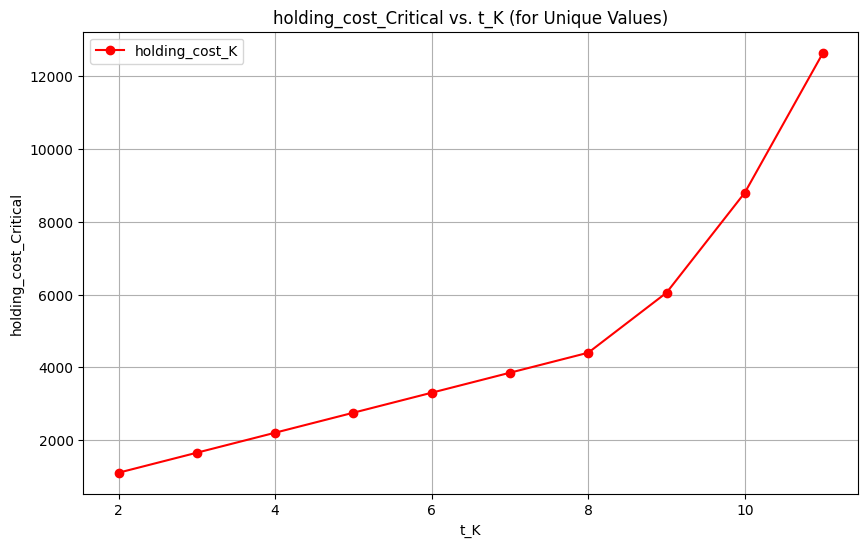

In [101]:
unique_t2_data = df[['t_K', 'holding_cost_K']].drop_duplicates()

plt.figure(figsize=(10, 6))
plt.plot(unique_t2_data['t_K'], unique_t2_data['holding_cost_K'], marker='o', color='r', label='holding_cost_K')
plt.title('holding_cost_Critical vs. t_K (for Unique Values)')
plt.xlabel('t_K')
plt.ylabel('holding_cost_Critical')

plt.legend()
plt.grid(True)
plt.show()

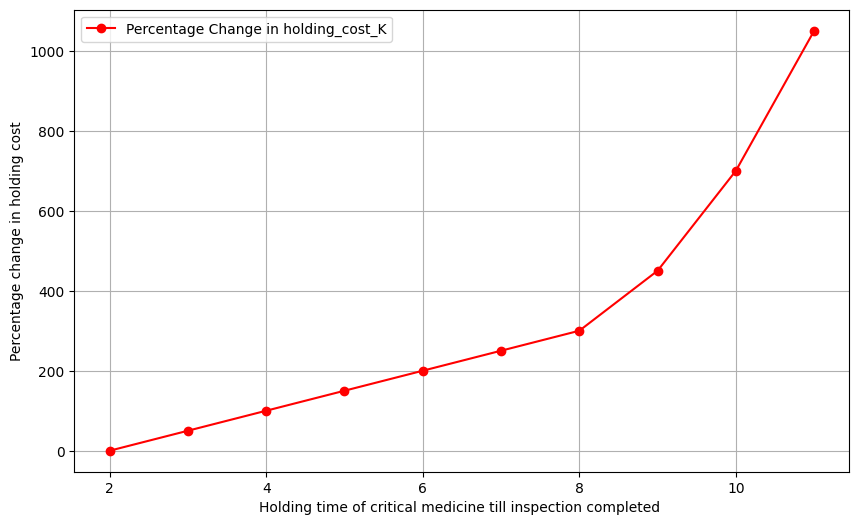

In [102]:
base_cost = unique_t2_data['holding_cost_K'].iloc[0]
unique_t2_data['percentage_change'] = ((unique_t2_data['holding_cost_K'] - base_cost) / base_cost) * 100
plt.figure(figsize=(10, 6))
plt.plot(unique_t2_data['t_K'], unique_t2_data['percentage_change'], marker='o', color='r', label='Percentage Change in holding_cost_K')

#plt.title('holding_cost_Critical and Percentage Change vs. t_K (for Unique Values)')
plt.xlabel('Holding time of critical medicine till inspection completed ')
plt.ylabel('Percentage change in holding cost')

plt.legend()
plt.grid(True)
plt.show()


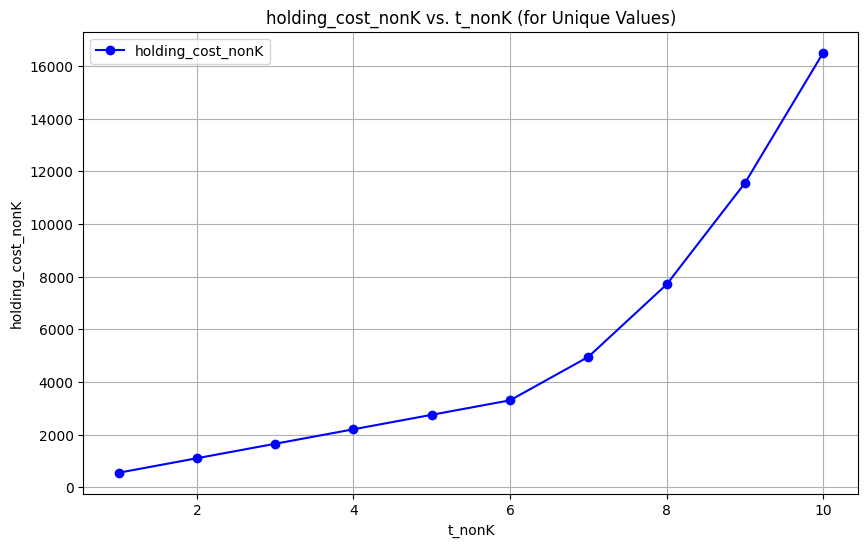

In [103]:
unique_t2_data = df[['t_nonK', 'holding_cost_nonK']].drop_duplicates()

plt.figure(figsize=(10, 6))
plt.plot(unique_t2_data['t_nonK'], unique_t2_data['holding_cost_nonK'], marker='o', color='b', label='holding_cost_nonK')
plt.title('holding_cost_nonK vs. t_nonK (for Unique Values)')
plt.xlabel('t_nonK')
plt.ylabel('holding_cost_nonK')

plt.legend()
plt.grid(True)
plt.show()

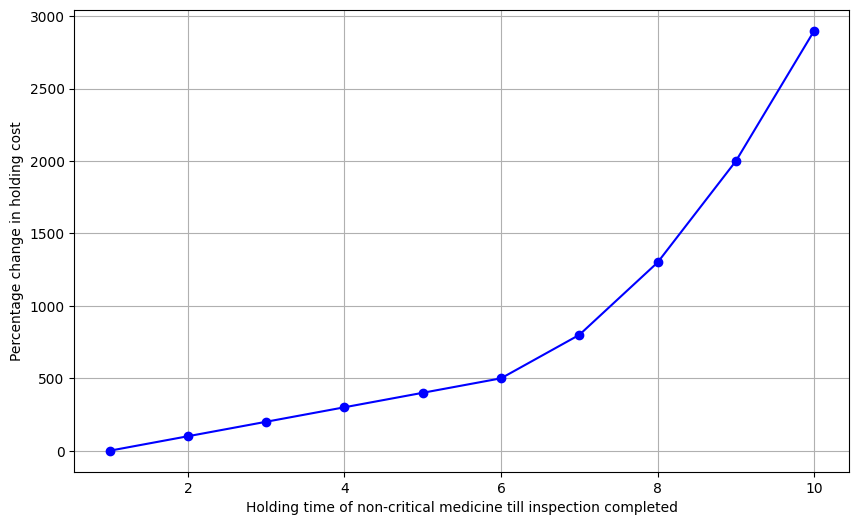

In [104]:
base_cost_nonK = unique_t2_data['holding_cost_nonK'].iloc[0]
unique_t2_data['percentage_change_nonK'] = ((unique_t2_data['holding_cost_nonK'] - base_cost_nonK) / base_cost_nonK) * 100

plt.figure(figsize=(10, 6))

plt.plot(unique_t2_data['t_nonK'], unique_t2_data['percentage_change_nonK'], marker='o', color='b', label='Percentage Change in holding_cost_nonK')

#plt.title('holding_cost_nonK and Percentage Change vs. t_nonK (for Unique Values)')
plt.xlabel('Holding time of non-critical medicine till inspection completed')
plt.ylabel('Percentage change in holding cost')

#plt.legend()
plt.grid(True)
plt.show()


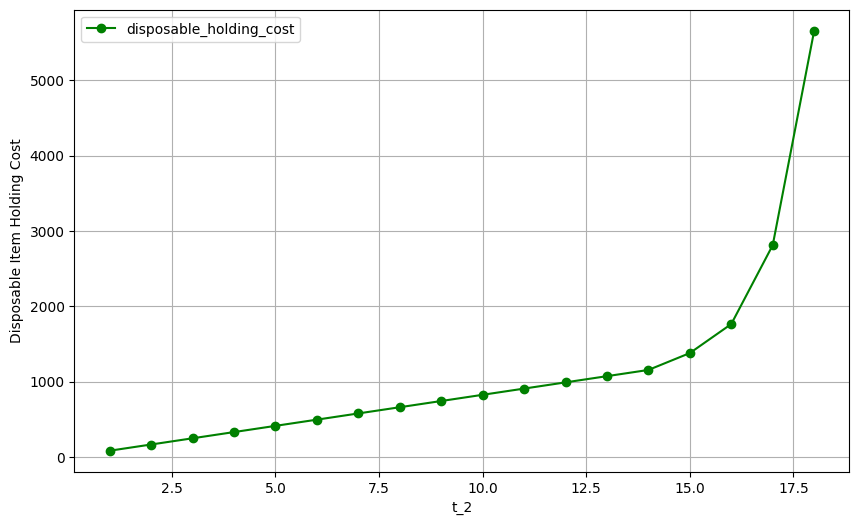

In [105]:
unique_t2_data = df[['t2', 'disposable_holding_cost']].drop_duplicates()

plt.figure(figsize=(10, 6))
plt.plot(unique_t2_data['t2'], unique_t2_data['disposable_holding_cost'], marker='o', color='g', label='disposable_holding_cost')
#plt.title('Disposal Item Holding Cost vs. t_2 (for Unique Values)')
plt.xlabel('t_2')
plt.ylabel('Disposable Item Holding Cost')

plt.legend()
plt.grid(True)
plt.show()

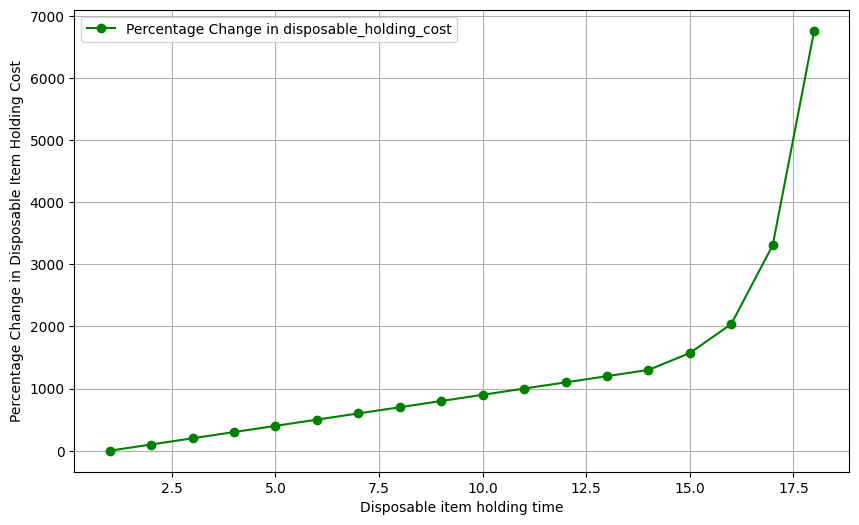

In [106]:
base_cost_disposable = unique_t2_data['disposable_holding_cost'].iloc[0]
unique_t2_data['percentage_change_disposable'] = ((unique_t2_data['disposable_holding_cost'] - base_cost_disposable) / base_cost_disposable) * 100

plt.figure(figsize=(10, 6))
plt.plot(unique_t2_data['t2'], unique_t2_data['percentage_change_disposable'], marker='o', color='g', label='Percentage Change in disposable_holding_cost')

#plt.title('Percentage Change in Disposable Holding Cost vs. t_2 (for Unique Values)')
plt.xlabel('Disposable item holding time')
plt.ylabel('Percentage Change in Disposable Item Holding Cost')

plt.legend()
plt.grid(True)
plt.show()

In [107]:
df1

,p_K,p_nonK,inspection_cost,transportation_cost,holding_cost_K,holding_cost_nonK,waiting_time_cost,disposable_holding_cost,repackaging_cost,disposal_cost,objective_value,percentage_change_obj_V,percentage_change_repack,percentage_change_disposal
0,0.05,0.10,2490.0,235.0,1100.0,550.0,55.0,82.5,4331.25,131.75,8975.50,0.000000,0.000000,0.000000
1,0.05,0.15,2475.0,251.0,1100.0,550.0,82.5,110.0,4221.25,172.00,8961.75,-0.153195,-2.539683,30.550285
2,0.05,0.20,2475.0,251.0,1100.0,550.0,110.0,137.5,4111.25,213.25,8948.00,-0.306390,-5.079365,61.859583
3,0.10,0.15,2490.0,235.0,1100.0,550.0,82.5,137.5,4097.50,221.25,8913.75,-0.687984,-5.396825,67.931689
4,0.10,0.20,2475.0,251.0,1100.0,550.0,110.0,165.0,3987.50,261.50,8900.00,-0.841179,-7.936508,98.481973
5,0.15,0.20,2475.0,251.0,1100.0,550.0,110.0,192.5,3863.75,309.75,8852.00,-1.375968,-10.793651,135.104364


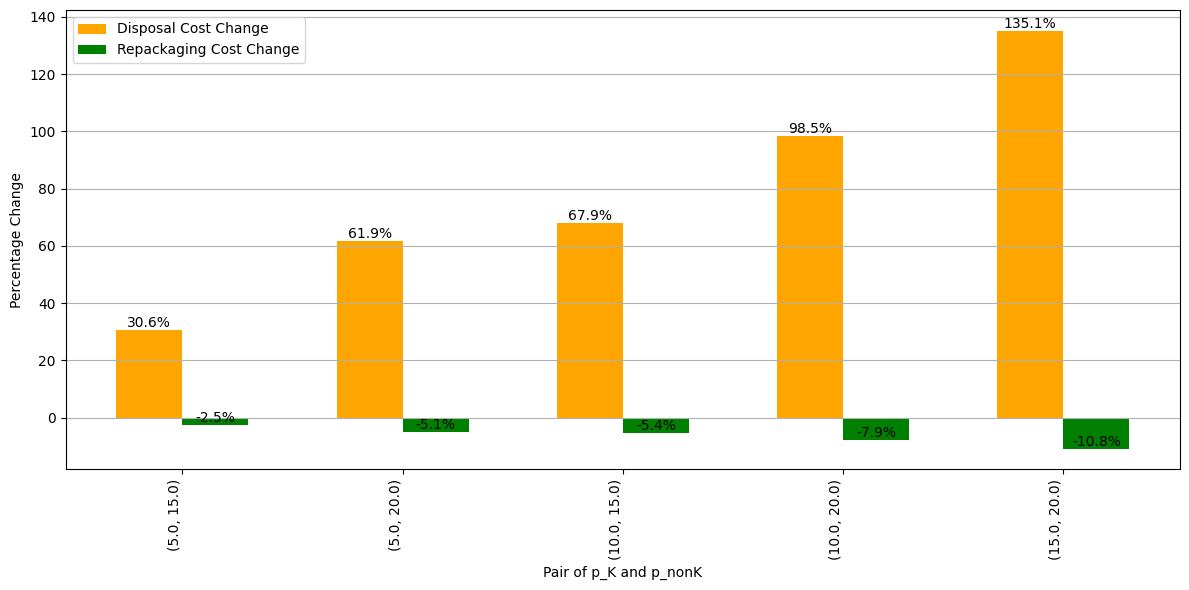

In [108]:
df1['p_K_p_nonK'] = df1.apply(lambda row: f"({row['p_K']*100}, {row['p_nonK']*100})", axis=1)

base_cost_disposal = df1['disposal_cost'].iloc[0]
base_cost_repackaging = df1['repackaging_cost'].iloc[0]

df1['percentage_change'] = (df1['disposal_cost'] - base_cost_disposal) / base_cost_disposal * 100
df1['percentage_change_repackaging'] = (df1['repackaging_cost'] - base_cost_repackaging) / base_cost_repackaging * 100


df1 = df1.iloc[1:]

plt.figure(figsize=(12, 6))
bar_width = 0.3  
index = range(len(df1))


bars1 = plt.bar([i - bar_width / 2 for i in index], df1['percentage_change'], width=bar_width, label='Disposal Cost Change', color='orange')
bars2 = plt.bar([i + bar_width / 2 for i in index], df1['percentage_change_repackaging'], width=bar_width, label='Repackaging Cost Change', color='green')


for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom', fontsize=10)


plt.xlabel('Pair of p_K and p_nonK')
plt.ylabel('Percentage Change')
plt.xticks(index, df1['p_K_p_nonK'], rotation=90, ha='right')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()

plt.show()

In [109]:
filtered_df

,t_K,t_nonK,t2,inspection_cost,transportation_cost,holding_cost_K,holding_cost_nonK,waiting_time_cost,disposable_holding_cost,repackaging_cost,disposal_cost,objective_value,percentage_change,sum_t
0,2,1,1,2490.0,235.0,1100.0,550.0,55.0,82.50,4331.25,131.75,8975.50,0.000000,4
14,2,1,15,2490.0,235.0,1100.0,550.0,55.0,1379.26,4331.25,131.75,10272.26,14.447774,18
360,7,6,1,2490.0,235.0,3850.0,3300.0,55.0,82.50,4331.25,131.75,14475.50,61.277923,14
374,7,6,15,2490.0,235.0,3850.0,3300.0,55.0,1379.26,4331.25,131.75,15772.26,75.725698,28
378,8,1,1,2490.0,235.0,4400.0,550.0,385.0,82.50,4331.25,131.75,12605.50,40.443429,10
392,8,1,15,2490.0,235.0,4400.0,550.0,385.0,1379.26,4331.25,131.75,13902.26,54.891204,24
468,8,6,1,2490.0,235.0,4400.0,3300.0,110.0,82.50,4331.25,131.75,15080.50,68.018495,15
482,8,6,15,2490.0,235.0,4400.0,3300.0,110.0,1379.26,4331.25,131.75,16377.26,82.466269,29


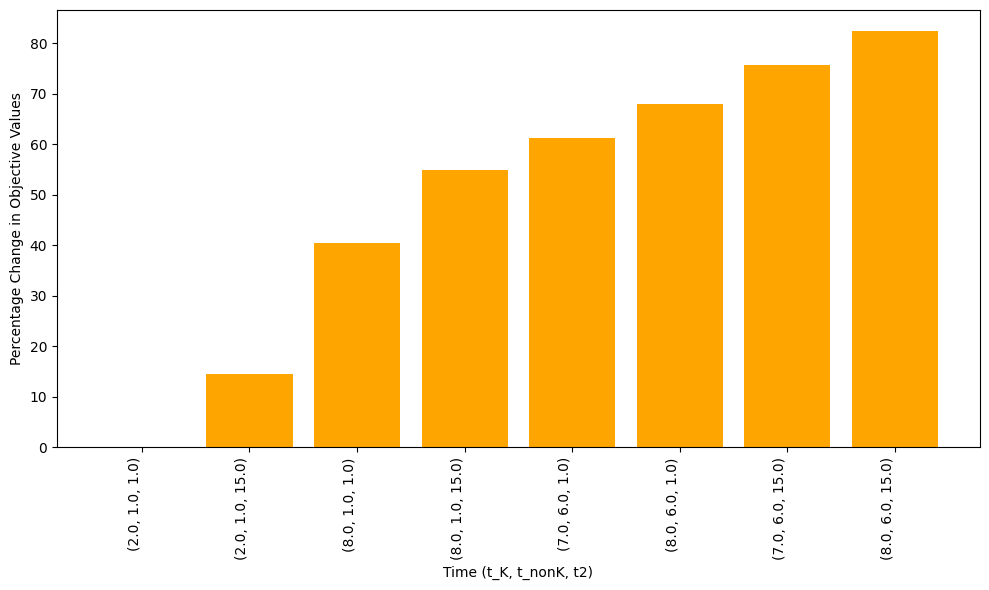

In [110]:
filtered_df = filtered_df.sort_values(by='percentage_change', ascending=True)


filtered_df['x_label'] = filtered_df.apply(lambda row: f"({row['t_K']}, {row['t_nonK']}, {row['t2']})", axis=1)


plt.figure(figsize=(10, 6))
plt.bar(filtered_df['x_label'], filtered_df['percentage_change'], color='orange')


plt.xlabel("Time (t_K, t_nonK, t2)")
plt.ylabel("Percentage Change in Objective Values")
#plt.title("Percentage Change Across Parameter Pairs")
plt.xticks(rotation=90, ha='right')
plt.tight_layout()

plt.show()


In [111]:
df1

,p_K,p_nonK,inspection_cost,transportation_cost,holding_cost_K,holding_cost_nonK,waiting_time_cost,disposable_holding_cost,repackaging_cost,disposal_cost,objective_value,percentage_change_obj_V,percentage_change_repack,percentage_change_disposal,p_K_p_nonK,percentage_change,percentage_change_repackaging
1,0.05,0.15,2475.0,251.0,1100.0,550.0,82.5,110.0,4221.25,172.00,8961.75,-0.153195,-2.539683,30.550285,"(5.0, 15.0)",30.550285,-2.539683
2,0.05,0.20,2475.0,251.0,1100.0,550.0,110.0,137.5,4111.25,213.25,8948.00,-0.306390,-5.079365,61.859583,"(5.0, 20.0)",61.859583,-5.079365
3,0.10,0.15,2490.0,235.0,1100.0,550.0,82.5,137.5,4097.50,221.25,8913.75,-0.687984,-5.396825,67.931689,"(10.0, 15.0)",67.931689,-5.396825
4,0.10,0.20,2475.0,251.0,1100.0,550.0,110.0,165.0,3987.50,261.50,8900.00,-0.841179,-7.936508,98.481973,"(10.0, 20.0)",98.481973,-7.936508
5,0.15,0.20,2475.0,251.0,1100.0,550.0,110.0,192.5,3863.75,309.75,8852.00,-1.375968,-10.793651,135.104364,"(15.0, 20.0)",135.104364,-10.793651


In [112]:
t_K = 2
t_nonK=1
t2 = 1

In [113]:
results = []

p_K_values = np.array([0.05])
p_nonK_values = np.array([0.10])


percentage_increases = [0.05, 0.10, 0.15,0.20,0.25,0.30,0.35]


C_K_original = np.array([5, 6, 7, 6])
C_nonK_original = np.array([4, 5, 4, 3])

for increase in percentage_increases:
    
    C_K = C_K_original * (1 + increase)
    C_nonK = C_nonK_original * (1 + increase)

    for p_K in p_K_values:
        for p_nonK in p_nonK_values:
            if p_K < p_nonK:
                
                model = LpProblem("Reverse_Logistics_Optimization", LpMinimize)

                x = LpVariable.dicts("x", (range(M), range(N)), cat='Binary')  
                y = LpVariable.dicts("y", (range(M), range(N)), cat='Binary')  
                z = LpVariable.dicts("z", (range(M), range(N)), cat='Binary')  
                z_K = LpVariable.dicts("z_K", (range(M), range(N), range(D)), cat='Binary')  
                z_nonK = LpVariable.dicts("z_nonK", (range(M), range(N), range(D)), cat='Binary')  
                w = LpVariable.dicts("w", (range(M), range(D)), cat='Binary')

                inspection_cost = lpSum(C_K[i] * Q_K[j] * x[i][j] for i in range(M) for j in range(N)) + \
                    lpSum(C_nonK[i] * Q_nonK[j] * y[i][j] for i in range(M) for j in range(N))

                transportation_cost = lpSum(T[i] * delta[i][j] * (x[i][j] + y[i][j] - z[i][j]) for i in range(M) for j in range(N))

                holding_cost_K = f(t_K, t10_K, H) * lpSum(Q_K[j] * x[i][j] for i in range(M) for j in range(N))
                holding_cost_nonK = f(t_nonK, t10_nonK, H) * lpSum(Q_nonK[j] * y[i][j] for i in range(M) for j in range(N))
                disposable_holding_cost = g(t2, t20, H) * lpSum(
                    p_K * Q_K[j] * x[i][j] + p_nonK * Q_nonK[j] * y[i][j]
                    for i in range(M) for j in range(N)
                )

                waiting_time_cost = lpSum(
                    H * (t_K - t_nonK) * p_nonK * Q_nonK[j] * y[i][j]
                    for i in range(M) for j in range(N)
                )

                repackaging_cost = R_K *lpSum( (1 - p_K) * lpSum(Q_K[j] * x[i][j] for j in range(N)) for i in range(M)) + \
                    R_nonK * lpSum( (1 - p_nonK) * lpSum(Q_nonK[j] * y[i][j] for j in range(N)) for i in range(M))

                disposal_cost = lpSum((C_disposal[i][d]) * (
                        p_K * lpSum(Q_K[j] * z_K[i][j][d] for j in range(N)) + \
                        p_nonK * lpSum(Q_nonK[j] * z_nonK[i][j][d] for j in range(N))
                    ) for i in range(M) for d in range(D))

                model += inspection_cost + transportation_cost + holding_cost_K + holding_cost_nonK + disposable_holding_cost + waiting_time_cost + repackaging_cost + disposal_cost

                for j in range(N):
                    model += lpSum(x[i][j] for i in range(M)) == 1  
                    model += lpSum(y[i][j] for i in range(M)) == 1

                for i in range(M):
                    model += lpSum(Q_K[j] * x[i][j] + Q_nonK[j] * y[i][j] for j in range(N)) <= Cap_IC[i]

                for i in range(M):
                    model += lpSum(w[i][d] for d in range(D)) == 1

                for i in range(M):
                    for j in range(N):
                        model += z[i][j] <= x[i][j]
                        model += z[i][j] <= y[i][j]
                        model += z[i][j] >= x[i][j] + y[i][j] - 1

                for i in range(M):
                    for j in range(N):
                        for d in range(D):
                            model += z_K[i][j][d] <= x[i][j]  
                            model += z_nonK[i][j][d] <= y[i][j]  
                            model += z_K[i][j][d] <= w[i][d]  
                            model += z_nonK[i][j][d] <= w[i][d]  
                            
                            model += z_K[i][j][d] >= x[i][j] + w[i][d] - 1
                            model += z_nonK[i][j][d] >= y[i][j] + w[i][d] - 1

                for d in range(D):
                    model += lpSum(p_K * Q_K[j] * z_K[i][j][d] + p_nonK * Q_nonK[j] * z_nonK[i][j][d] 
                                   for i in range(M) for j in range(N)) <= Cap_disposal[d]

                model.solve()

                results.append({
                    "increase": increase,
                    "p_K": p_K,
                    "p_nonK": p_nonK,
                    
                    "inspection_cost": inspection_cost.value(),
                    "transportation_cost": transportation_cost.value(),
                    "holding_cost_K": holding_cost_K.value(),
                    "holding_cost_nonK": holding_cost_nonK.value(),
                    "waiting_time_cost": waiting_time_cost.value(),
                    "disposable_holding_cost": disposable_holding_cost.value(),
                    "repackaging_cost": repackaging_cost.value(),
                    "disposal_cost": disposal_cost.value(),
                    "objective_value": model.objective.value()
                })

df1 = pd.DataFrame(results).round(2)
print(df1)


   increase   p_K  p_nonK  inspection_cost  transportation_cost  \
0      0.05  0.05     0.1          2598.75                251.0   
1      0.10  0.05     0.1          2722.50                251.0   
2      0.15  0.05     0.1          2829.00                268.0   
3      0.20  0.05     0.1          2952.00                268.0   
4      0.25  0.05     0.1          3075.00                268.0   
5      0.30  0.05     0.1          3198.00                268.0   
6      0.35  0.05     0.1          3321.00                268.0   

   holding_cost_K  holding_cost_nonK  waiting_time_cost  \
0          1100.0              550.0               55.0   
1          1100.0              550.0               55.0   
2          1100.0              550.0               55.0   
3          1100.0              550.0               55.0   
4          1100.0              550.0               55.0   
5          1100.0              550.0               55.0   
6          1100.0              550.0              

In [114]:
base_value = 8975.5
df1['percentage_change_OV'] = ((df1['objective_value'] - base_value) / base_value) * 100
print(df1)

   increase   p_K  p_nonK  inspection_cost  transportation_cost  \
0      0.05  0.05     0.1          2598.75                251.0   
1      0.10  0.05     0.1          2722.50                251.0   
2      0.15  0.05     0.1          2829.00                268.0   
3      0.20  0.05     0.1          2952.00                268.0   
4      0.25  0.05     0.1          3075.00                268.0   
5      0.30  0.05     0.1          3198.00                268.0   
6      0.35  0.05     0.1          3321.00                268.0   

   holding_cost_K  holding_cost_nonK  waiting_time_cost  \
0          1100.0              550.0               55.0   
1          1100.0              550.0               55.0   
2          1100.0              550.0               55.0   
3          1100.0              550.0               55.0   
4          1100.0              550.0               55.0   
5          1100.0              550.0               55.0   
6          1100.0              550.0              

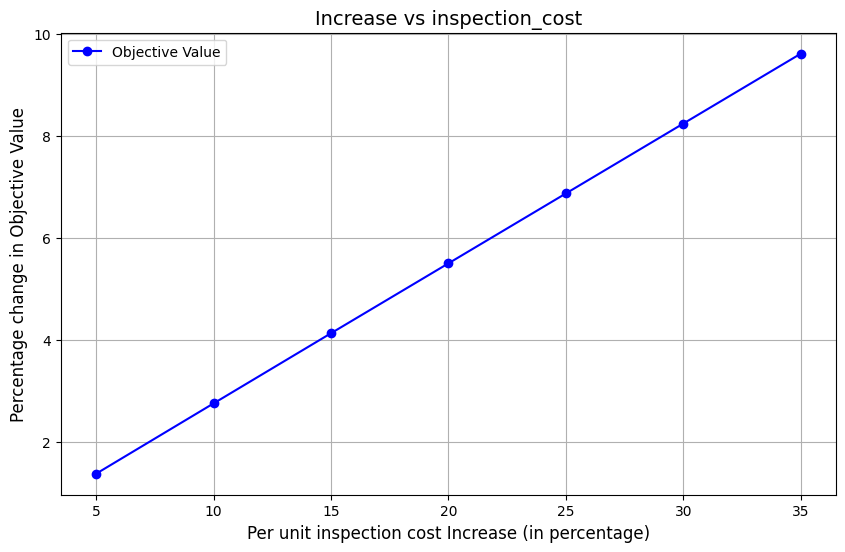

In [115]:
plt.figure(figsize=(10, 6))
plt.plot(df1['increase']*100, df1['percentage_change_OV'], marker='o', linestyle='-', color='b', label='Objective Value')
plt.xlabel('Per unit inspection cost Increase (in percentage)', fontsize=12)
plt.ylabel('Percentage change in Objective Value', fontsize=12)
plt.title('Increase vs inspection_cost', fontsize=14)
plt.grid(True)
plt.legend()


plt.show()

In [116]:
base_value1 = 2490.0
df1['percentage_change_Ins_C'] = ((df1['inspection_cost'] - base_value1) / base_value1) * 100
print(df1)

   increase   p_K  p_nonK  inspection_cost  transportation_cost  \
0      0.05  0.05     0.1          2598.75                251.0   
1      0.10  0.05     0.1          2722.50                251.0   
2      0.15  0.05     0.1          2829.00                268.0   
3      0.20  0.05     0.1          2952.00                268.0   
4      0.25  0.05     0.1          3075.00                268.0   
5      0.30  0.05     0.1          3198.00                268.0   
6      0.35  0.05     0.1          3321.00                268.0   

   holding_cost_K  holding_cost_nonK  waiting_time_cost  \
0          1100.0              550.0               55.0   
1          1100.0              550.0               55.0   
2          1100.0              550.0               55.0   
3          1100.0              550.0               55.0   
4          1100.0              550.0               55.0   
5          1100.0              550.0               55.0   
6          1100.0              550.0              

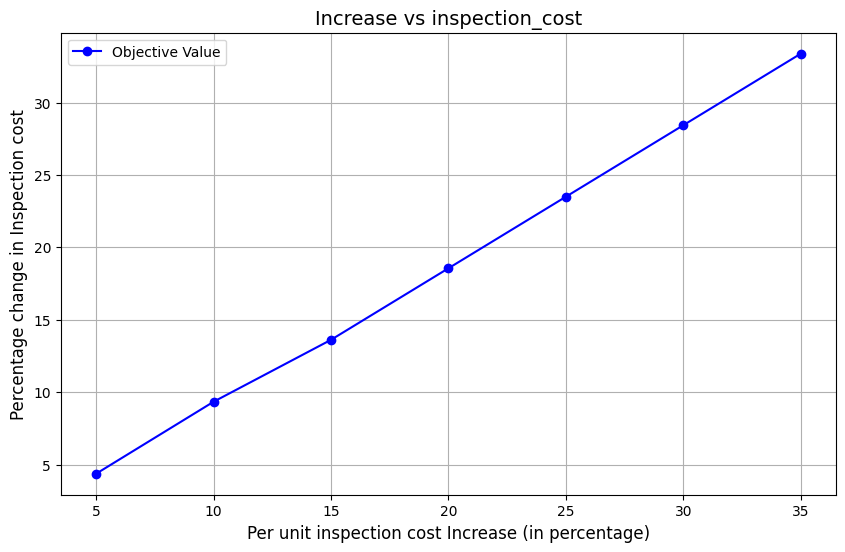

In [117]:
plt.figure(figsize=(10, 6))
plt.plot(df1['increase']*100, df1['percentage_change_Ins_C'], marker='o', linestyle='-', color='b', label='Objective Value')
plt.xlabel('Per unit inspection cost Increase (in percentage)', fontsize=12)
plt.ylabel('Percentage change in Inspection cost', fontsize=12)
plt.title('Increase vs inspection_cost', fontsize=14)
plt.grid(True)
plt.legend()


plt.show()

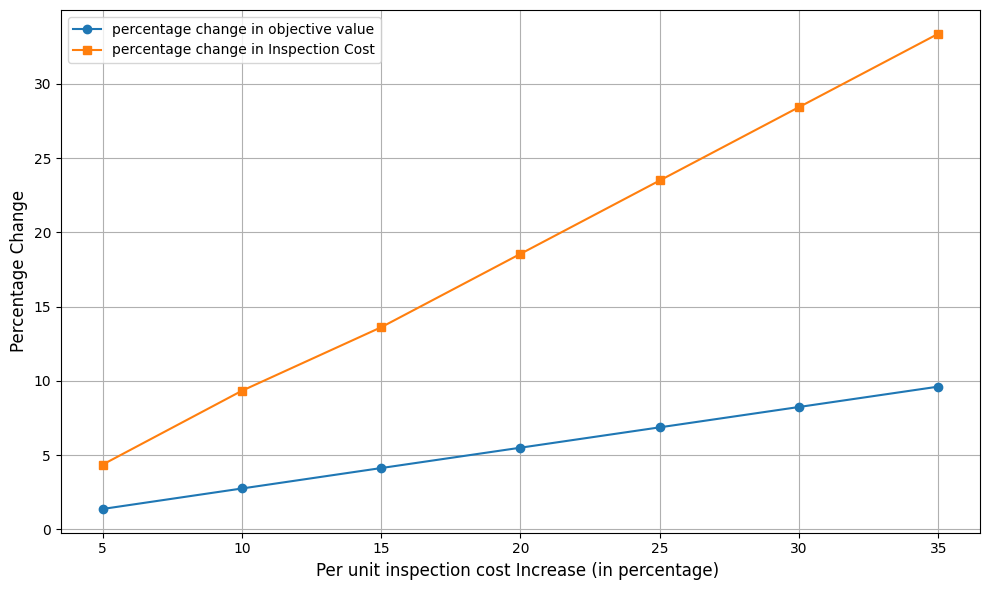

In [118]:
plt.figure(figsize=(10, 6))
plt.plot(df1['increase']*100, df1['percentage_change_OV'], label='percentage change in objective value', marker='o')
plt.plot(df1['increase']*100, df1['percentage_change_Ins_C'], label='percentage change in Inspection Cost', marker='s')

plt.xlabel('Per unit inspection cost Increase (in percentage) ', fontsize=12)
plt.ylabel('Percentage Change', fontsize=12)
#plt.title('Percentage Change vs Increase', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()